# ΕΡΓΑΣΙΑ 3: ΒΑΘΙΑ ΜΑΘΗΣΗ

OMAΔΑ 53 
* Αθανασίου Ιωάννης       03117041 
* Καραβαγγέλης Αθανάσιος     03117022 

## Εγκατάσταση πακέτων

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade tensorflow
!pip install --upgrade tqdm

## Dataset

* Θα χρησιμοποιήσουμε το dataset flickr30k-images-ecemod.
* Το χρησιμοποιούμε μέσω kaggle κάνοντας Add Data.

## Tutorial του Tensorflow

* Θα χτίσουμε εκ νέου το μοντέλο του [tutorial](https://www.tensorflow.org/tutorials/text/image_captioning), για να μετρήσουμε χρόνους εκπαίδευσης, loss και BLEU.
* Έτσι, στην συνέχεια, θα μπορούμε να το συγκρίνουμε πιο λεπτομερώς με το βελτιστοποιημένο δίκτυο που θα χτίσουμε.  

In [ ]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
import pickle
from pickle import load, dump
from PIL import Image
import re, collections
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from collections import defaultdict
from tqdm import tqdm
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction



### Ελέγχουμε την μορφή των data που έχουμε ήδη φορτώσει:

In [ ]:
import pandas as pd

train_captions = pd.read_csv(
    "../input/neuralsntua-image-captioning/train_captions.csv",
    names=["image", "caption_index", "caption"],
    sep='|')
train_images = train_captions['image']
train_captions

,image,caption_index,caption
0,_1000070808.jpg,0,A little girl holds orange lilies while other...
1,_1000070808.jpg,1,A little girl at a wedding holds a bouquet of...
2,_1000070808.jpg,2,Young girl in orange dress holding orange flo...
3,_1000070808.jpg,3,a girl at a wedding holding some orange flowers
4,_1000070808.jpg,4,A girl holds a bouquet of flowers
...,...,...,...
148910,_99999606.jpg,0,A man in a gray shirt sits with several pairs...
148911,_99999606.jpg,1,A man is sitting down and he is surrounded by...
148912,_99999606.jpg,2,Older man with shoes in front and behind him .
148913,_99999606.jpg,3,This man has worked here for many decades .


In [ ]:
test_images = pd.read_csv("../input/neuralsntua-image-captioning/test_images.csv")
test_images

,_1000400860.jpg
0,_100046208.jpg
1,_1000933460.jpg
2,_1003969002.jpg
3,_10042424.jpg
4,_100654872.jpg
...,...
1994,_994748436.jpg
1995,_99541900.jpg
1996,_997103085.jpg
1997,_99794568.jpg


### Ομαδοποιούμε τα captions ανά image:

In [ ]:
import collections

image_captions = collections.defaultdict(list)
rows = train_captions.to_dict('records')
for row in rows:
  caption, image = row['caption'], row['image']
  image_captions[image].append(f"<start> {caption} <end>")


In [ ]:
print(image_captions['_1000070808.jpg'])
print(image_captions['_111343239.jpg'])

['<start>  A little girl holds orange lilies while others celebrate an occasion in a garden setting . <end>', '<start>  A little girl at a wedding holds a bouquet of orange flowers . <end>', '<start>  Young girl in orange dress holding orange flowers . <end>', '<start>  a girl at a wedding holding some orange flowers <end>', '<start>  A girl holds a bouquet of flowers <end>']
['<start>  One black dog chases another on grass nearby a road that was recently snowed on . <end>', '<start>  Two black dogs are playing in a grassy plain . <end>', '<start>  Two black dogs chase each other on grass . <end>', '<start>  Two black dogs running on grass . <end>', '<start>  Two black dogs running <end>']


* Αναμένουμε 5 captions ανά image:

In [ ]:
for l in image_captions.values():

  if (len(l)!=5):
    image = list(image_captions.keys())[list(image_captions.values()).index(l)]
    print(f"Oops, Image {image} has more than 5 captions.")
    

Oops, Image _287255355.jpg has more than 5 captions.


* Παρατηρώ ότι στο image `_287255355.jpg` υπάρχουν περισσότερα captions, οπότε θα αλλάξω τα captions που του αντιστοιχούν με το χέρι:

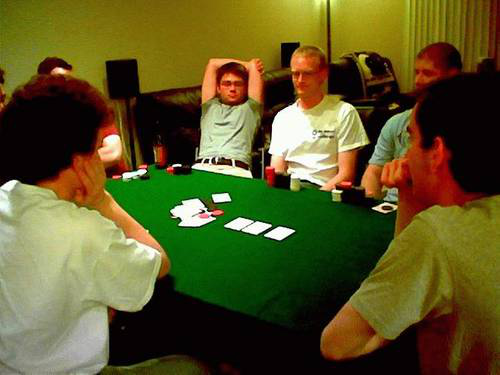

In [ ]:
Image.open('../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/_287255355.jpg')

In [ ]:
image_captions['_287255355.jpg']

['<start>  A young boy in a red jacket and a child in a blue jacket sitting on the bank next to water . <end>',
 '<start>  Two children , one in a red coat , one in a blue coat , are sitting by a lake . <end>',
 "<start>  Two children are sitting by the calm water 's edge . <end>",
 '<start>  Kids sitting by the dock of the bay , cute kids . <end>',
 '<start>  Two young boys sit by a lake . <end>',
 '<start>  A group of friends playing cards and trying to bluff each other into making a terrible mistake . <end>',
 '<start>  A group of college students gathers to play texas hold em poker . <end>',
 '<start>  Several men play cards while around a green table . <end>',
 '<start>  A group of several men playing poker . <end>',
 '<start>  Six white males playing poker . <end>']

* Παρατηρώ ότι οι 5 πρώτες περιγραφές δεν έχουν σχέση με την εικόνα, οπότε τις αφαιρώ:

In [ ]:
image_captions['_287255355.jpg'] = image_captions['_287255355.jpg'][5:] 

In [ ]:
image_captions['_287255355.jpg']

['<start>  A group of friends playing cards and trying to bluff each other into making a terrible mistake . <end>',
 '<start>  A group of college students gathers to play texas hold em poker . <end>',
 '<start>  Several men play cards while around a green table . <end>',
 '<start>  A group of several men playing poker . <end>',
 '<start>  Six white males playing poker . <end>']

* Ελέγχω και μία άλλη τυχαία εικόνα:

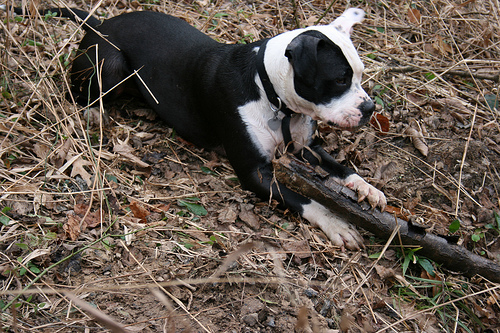

In [ ]:
import random
path = random.choice(list(image_captions.keys()))
Image.open(f"../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/{path}")

In [ ]:
for caption in image_captions[path]:
  print(caption)

<start>  A black and white dog holds a stick in his paw for chewing or playing . <end>
<start>  a black and white staffordshire terrier has his paw on large branch <end>
<start>  A black and white dog laying down with a big stick under its paw . <end>
<start>  There is a black and white dog chewing on a branch outside . <end>
<start>  The black and white dog has a stick in his paws . <end>


### Μοντέλο InceptionV3

* Αρχικά χρησιμοποιήσαμε το pretrained model `InceptionV3` για να εξαγάγουμε τα features των εικόνων και να δούμε τη συμπεριφορά του μοντέλου.
* Το μοντέλο αυτό, ως input δέχεται τις εικόνες με διαστάσεις 299x299 και με τις τιμές των pixels κανονικοποιημένες στο [0, 1].


#### Προεπεξεργασία των εικόνων

* Ορίζω την συνάρτηση `process_image` που επεξεργάζεται μία εικόνα, λαμβάνοντας ως όρισμα το path της.

In [ ]:
def process_image(path):
  # decode image to np array
  img = tf.io.read_file("../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/" + train_images[0])
  img = tf.io.decode_jpeg(img, channels=3)
  # re-shape the image
  img = tf.keras.layers.Resizing(299, 299)(img)
  # normalize the pixels values
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return path, img

* Δοκιμάζω στην εικόνα της πρώτης γραμμής του training dataset:

In [ ]:
path = "../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/" + train_images[0]
path_, img = process_image(path)
img

#### Αρχικοποίηση του μοντέλου InceptionV3 με χρήση των pretrained weights

In [ ]:
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)

In [ ]:
input = inception_model.input
hidden_layer = inception_model.layers[-1].output
image_features_extract_model = tf.keras.Model(input, hidden_layer)

In [ ]:
image_features_extract_model.summary()

### Μοντέλο InceptionResNetV2

H ομάδα μας είναι η 53 άρα με βάση τους κανόνες της εργασίας (53 mod 4) = 1 και άρα μας αντιστοιχεί το μοντέλο InceptionResNetV2.

* Αυτό είναι το μοντέλο που χρησιμοποιήσαμε για την εξαγωγή των τελικών μας αποτελσμάτων, αφου πρώτα εξοικειωθήκαμε με τις διαδικασίες με το μοντέλο InceptionV3 του tutorial.
* Το μοντέλο αυτό, ως input δέχεται τις εικόνες με διαστάσεις 299x299 και με τις τιμές των pixels κανονικοποιημένες στο [0, 1].


#### Προεπεξεργασία των εικόνων

* Ορίζω την συνάρτηση `process_image_ResNet` που επεξεργάζεται μία εικόνα, λαμβάνοντας ως όρισμα το path της και χρησιμοποιεί την αντίστοιχη συνάρτηση preprocess_input για το συγκεκριμένο δίκτυο.

In [ ]:
def process_image_ResNet(path):
  # decode image to np array
  img = tf.io.read_file("../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/" + path)
  img = tf.io.decode_jpeg(img, channels=3)
  # re-shape the image
  img = tf.keras.layers.Resizing(299, 299)(img)
  # normalize the pixels values
  img =  tf.keras.applications.inception_resnet_v2.preprocess_input(img)
  return path, img
  

* Δοκιμάζω στην εικόνα της πρώτης γραμμής του training dataset:

In [ ]:
ResNet_path = train_images[0]
ResNet_path_, ResNet_img = process_image_ResNet(ResNet_path)
ResNet_img

#### Αρχικοποίηση του μοντέλου InceptionResNetV2 με χρήση των pretrained weights

In [ ]:
ResNet_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet'
)

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
input = ResNet_model.input
hidden_layer = ResNet_model.layers[-1].output
image_features_extract_model = tf.keras.Model(input, hidden_layer)

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Χρήση του inceptionResNetV2 για features extraction

In [ ]:
paths = []
#for path in train images
vals = sorted(set(train_images.values))
# apply the process_image method to the train_images 
image_dataset = tf.data.Dataset.from_tensor_slices(vals)
image_dataset = image_dataset.map(process_image_ResNet, num_parallel_calls=tf.data.AUTOTUNE).batch(16)"""

In [ ]:
from tqdm import tqdm

for path, img in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

> Για να μην δημιουργούμε συνέχεια τα αρχεία .npy, και για καλύτερη χρήση της μνήμης που μας δίνεται, δημιουργήσαμε ένα dataset στο kaggle με τα .npy αρχεία για τις εικόνες και τα χρησιμοποιούσαμε από εκεί.

### Προεπεξεργασία και tokenization των captions

* Έχω κρατήσει όλα τα captions, αντιστοιχισμένα στο path του image όπου αντιστοιχούν, στο dictionary `image_captions`:

Ελέγχω πως τόσο η λίστα με τα captions όσο και αυτή με τα image names έχουν ίδια μήκη. 

In [ ]:
image_captions_flat = [caption for captions in image_captions.values() for caption in captions]
image_names_flat = []
for key in image_captions.keys():
    image_names_flat.extend([key]*5)
if len(image_names_flat) == len(image_captions_flat):
    print(f"The size of both lists is: {len(image_names_flat)}")

The size of both lists is: 148910


* Θα προσπαθήσουμε να κρατήσουμε μόνο τα captions αυτά που έχουν ούτε πολύ μικρό ούτε πολύ μεγάλο μήκος.

In [ ]:
#count the length of each caption minus 2 because of the <start> and <end> tokens
image_captions_lengths = [len(re.split(r'\s{1,}',cap))-2 for cap in image_captions_flat]
#sorted list based on the length occurences
image_captions_lengths_sorted = list(collections.Counter(image_captions_lengths).most_common())
print(f"Most common caption length is: {image_captions_lengths_sorted[0][0]} with the number of such captions being {image_captions_lengths_sorted[0][1]}")

#count new number of captions
sum=0
image_captions_lengths_sorted = [item for item in image_captions_lengths_sorted if item[0] in [j for j in range(4,24)]]
for item in image_captions_lengths_sorted:
  sum += item[1]
print(f"Keeping captions with length in a window of the 20 most common lengths around length 11 we will keep... {sum} , out of {len(train_captions)} total captions.")

new_image_captions_flat = image_captions_flat.copy()
new_image_names_flat = image_names_flat.copy()
for i in range(len(image_captions_flat)):
  item = image_captions_flat[i]
  name = image_names_flat[i]
  words=len(re.split(r'\s{1,}',item))-2
  if words>23 or words<4:
    new_image_captions_flat.remove(item)
    new_image_names_flat.remove(name)




Most common caption length is: 11 with the number of such captions being 14517
Keeping captions with length in a window of the 20 most common lengths around length 11 we will keep... 141479 , out of 148915 total captions.


* Βλέπουμε ότι το πιο σύνηθες μήκος είναι **11**.
 > Κρατάμε μόνο τα captions με μήκος που θα βρίσκεται σε ένα παράθυρο πλάτους 20 γύρω από την τιμή 11. Αυτό το παράθυρο θα είναι από 4 έως 23 προκειμένου να μην κρατήσουμε πολύ μικρά captions (κάτω των 4 λέξεων).
* Έπειτα ελέγχουμε ότι έχουμε κρατήσει ίδιο πλήθος captions με το συνολικό πλήθος captions που βρήκαμε για το παράθυρο γύρω από το μήκος 11.

In [ ]:
print(len(new_image_captions_flat))

141479


Ελέγχω πάλι ότι υπάρχει αντιστοιχία captions και images, τυπώνοντας μία τυχαία εικόνα και το αντίστοιχο caption.

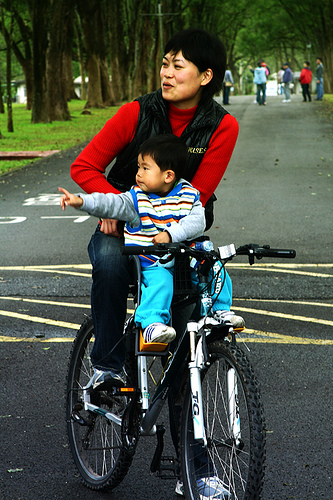

In [ ]:
Image.open('../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/'+new_image_names_flat[4760])

In [ ]:
new_image_captions_flat[4760]

'<start>  A mother with a kid on a bicycle . <end>'

### Ιστόγραμμα κατανομής μηκών captions
* Το ιστόγραμμα που περιγράφει ότι το πιο σύνηθες μήκος είναι 11 και όπου φαίνεται η κατανομή των μηκών, φαίνεται παρακάτω, και με πιο ανοιχτό χρώμα απεικονίζονται τα πιο συνήθη μήκη.

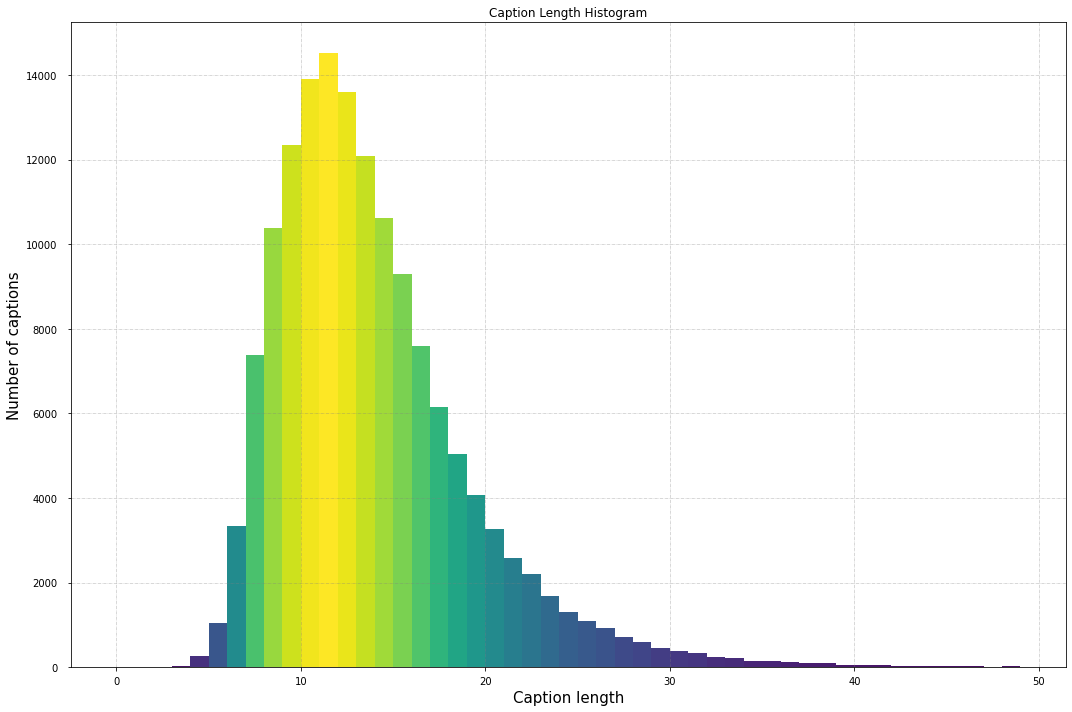

In [ ]:
#creating histogram
mybins = [i for i in range(50)]
fig, axs = plt.subplots(1, 1,
                        figsize =(15, 10),
                        tight_layout = True)

#For a nice histogram we borrowed some code from: https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/ 
N, bins, patches = axs.hist(image_captions_lengths, bins=mybins,range=[0, 50], facecolor='gray', align='mid')

fracs = ((N**(1 / 2)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

plt.ylabel("Number of captions",fontsize=15)
plt.xlabel("Caption length",fontsize=15)
plt.title('Caption Length Histogram')
 
#show plot
plt.show()

### Tokenizer

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(new_image_captions_flat)

max_length = 23
vocabulary_size = 10000

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length,
)

tokenizer.adapt(caption_dataset)

2022-03-13 19:41:55.706992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


* Δοκιμάζω την tokenizer σε μία τυχαία συμβολοσειρά:

In [ ]:
tokenizer("It's just a dummy string")

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([   1,  486,    2, 4263, 1196,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>

### Τrimming function
* H παρακάτω είναι μία συνάρτηση που ελέγχει ποια captions δεν συμπεριλαμβάνουν τουλάχιστον μία λέξη από το vocabulary μας και κάνει "trimming" στα captions, αφήνωντας μόνο αυτά που έχουν όλες τους τις λέξεις στο vocabulary μας.
> Τελικά δε την χρησιμοποιήσαμε για τα runs μας αφού είδαμε πως κάνει αρκετά μεγάλο trimming αφήνοντας μόλις 7000 περίπου captions από τα 141000. \
> Ωστόσο δείχνουμε τη χρήση της παρακάτω. 

In [ ]:
# only keep the decriptions that have the words from our vocab
def trimRareWords(desc, desc_images):
    
    num_des = 0
    num_trim = 0
    desc_result = []
    desc_images_result = []
        
    # Filter out pairs with trimmed words
    for i in tqdm(range(len(desc))):
        num_des += 1
        keep_input = True
        
        #Keep only sentences with less than 2 words out of our vocabulary.
        bad_w=0
        # Check input sentence
        for word in desc[i].split(' '):
            if word not in tokenizer.get_vocabulary():
                keep_input = False
                break

        # Only keep descriptions that do not contain trimmed word(s) in them
        if keep_input:
            num_trim += 1
            desc_result.append(desc[i])
            desc_images_result.append(desc_images[i])

    print("\nTrimmed from {} pairs to {}".format(num_des, num_trim))
    return desc_result, desc_images_result

In [ ]:
new_captions , new_images = trimRareWords(new_image_captions_flat[:100], new_image_names_flat[:100])

100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


Trimmed from 100 pairs to 7


* Εφαρμόζω την tokenizer στο dataset των captions:

In [ ]:
captions_tokenized = caption_dataset.map(lambda x: tokenizer(x))

* Ορίζω αντιστοιχήσεις μεταξύ λέξεων και των indexes τους στο vocabulary:

In [ ]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True,
)

In [ ]:
index_to_word(4)
print(word_to_index(['a']))

tf.Tensor([2], shape=(1,), dtype=int64)


* Θα χρησιμοποιήσουμε τα `captions_tokenized` και `new_image_names_flat`, ώστε να έχουμε δύο λίστες με την αντιστοιχία (`image name` -> `image caption tokenized`) στα ίδια indexes:

In [ ]:
image_names = new_image_names_flat
print("Images names:", len(image_names))
print("Tokenized captions:", len(captions_tokenized))

Images names: 141479
Tokenized captions: 141479


* Ουσιαστικά, χτίζω ένα παρόμοιο dictionary με το `image_captions`, αλλά τώρα το ονομάζω `image_captions_vector`, και αποθηκεύω τα `vectors` των captions, όπως προκύπτουν από τον tokenizer.  

In [ ]:
import collections

image_captions_vector = collections.defaultdict(list)
for img, cap in zip(image_names, captions_tokenized):
    image_captions_vector[img].append(cap)

In [ ]:
print(len(image_captions_vector.keys()))
print(len(image_captions_vector.values()))

29779
29779


### Χωρίζω τα training - validation - test sets

* Παρατηρώ ότι τα test images δίνονται χωρίς captions.
* Επομένως, χωρίζω το training set μου σε δύο νέα sets με ποσοστό 80%-20%, ώστε το ένα από αυτά να χρησιμοποιηθεί ως testing set.
* Aκόμα χρησιμοποιώ το 10% του training set ως validation set.

In [ ]:
# train-val => 80%
# test => 20%
slice_index_test = int( len(image_captions_vector.keys()) * 0.8 )

# train => 90%
# val => 10%
slice_index_val = int( slice_index_test * 0.9)

# seperate the keys for each set
image_train_keys = list(image_captions_vector.keys())[:slice_index_val]
image_validation_keys = list(image_captions_vector.keys())[slice_index_val:slice_index_test]
image_test_keys = list(image_captions_vector.keys())[slice_index_test:]

# populate the train set
image_names_train = []
image_captions_train = []
for image_name in image_train_keys:
  image_names_train.extend([image_name]*len(image_captions_vector[image_name]))
  image_captions_train.extend(image_captions_vector[image_name])

# populate the validation set
image_names_validation = []
image_captions_validation = []
for image_name in image_validation_keys:
    image_names_validation.extend([image_name]*len(image_captions_vector[image_name]))
    image_captions_validation.extend(image_captions_vector[image_name])

# populate the test set
image_names_test = []
image_captions_test = []
for image_name in image_test_keys:
  image_names_test.extend([image_name]*len(image_captions_vector[image_name]))
  image_captions_test.extend(image_captions_vector[image_name])


In [ ]:
assert len(image_names_train)==len(image_captions_train)
assert len(image_names_validation)==len(image_captions_validation)
assert len(image_names_test)==len(image_captions_test)

* Δημιουργούμε το validation_set που είναι ένα dictionary με keys τα ονόματα των εικόνων αλλά με διαφορετικό αριθμό captions ανά εικόνα, αναλόγως πόσες "κόπηκαν" στην προεπεξεργασία.

In [ ]:
# keeping the validation set as a dict of lists
validation_set = defaultdict(list)

for (name, caption) in zip(image_names_validation, image_captions_validation):
    validation_set[name].append(caption)


* To validation set έχει μήκος 2383 εικόνες με 3-5 captions η κάθε μία.

In [ ]:
len(validation_set.keys())

2383

### Δημιουργία του training dataset, από το `image_captions_train`

* Θα δοκιμάσουμε διάφορες τιμές για τις μονάδες GRU. 
* Επίσης θα δοκιμάσουμε να χρησιμοποιήσουμε επίσης **LSTM** αντί για **GRU**.

### Ηyperparameters

Οι τελικές υπερπαραμέτροι με τις οποίες βγάλαμε τα τελικά μας αποτελέσματα είναι οι παρακάτω.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 200
units = 512
num_steps = len(image_names_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048) and from InceptionResNetV2 is (64,1536)
# These two variables represent that vector shape
features_shape = 1536
attention_features_shape = 64

Δοκιμάσαμε τα εξής: 
* Παραπάνω units (776). 
* LSTM αντί για GRU όπου δεν είδαμε σημαντική διαφορά.
* Διαφορετικό BATCH_SIZE (32, 128) όμως φαίνεται πως η ισότητα με τα attention_features είναι η βέλτιστη από άποψη ταχύτητας.


In [ ]:
# Load the numpy files
def load_np_files(img_name, caption):
  img_tensor = np.load('../input/flickr-npy-outputs/'+img_name.decode('utf-8')+'.npy')
  return img_tensor, caption

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_names_train, list(image_captions_train)))

# Use map to load the numpy files in parallel
dataset = dataset.map(
  lambda item1, item2:
    tf.numpy_function(
          load_np_files,
          [item1, item2],
          [tf.float32, tf.int64]
    ),
  num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Μοντέλο

### Regularization

Το δίκτυο του tutorial δεν έχει κανένα μηχανισμό ομαλοποίησης,θα προσθέσουμε επίπεδα **Dropout** κοντά στα πυκνά επίπεδα του Decoder. \
Αυτό που καθιστά χρήσιμα τα Dropout layers είναι πως δίνουν στο δίκτυο τη δυνατότητα να αναπτύξει πολλαπλές εσωτερικές διασυνδέσεις, αφού κάποιοι νευρώνες γίνονται τυχαία "dropped out", αναγκάζοντας άλλους να εξάγουν τις προβλέψεις για εκείνους. 
 > Θα χρησιμοποιήσουμε dropout rate 0.25. 


### Embeddings

Θα χρησιμοποιήσουμε έτοιμα embeddings με μεταφορά μάθησης , κάτι που θα μειώσει και το πλήθος των βαρών προς εκπαίδευση. \
Θα δοκιμάσουμε με τα embeddings **glove wiki του Gensim** με διαστάσεις \[50,100,200,300\] ('glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300')

In [ ]:
import gensim.downloader
#select from [50, 100, 200, 300]
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-'+str(embedding_dim))

[================================================--] 96.9% 244.2/252.1MB downloaded

Με την παρακάτω συνάρτηση φτιάχνουμε ένα embedding matrix που θα χρησιμοποιηθεί στο Embedding layer του decoder.

In [ ]:
# Function that builds the weights for the embeddings layer
def make_embedding_matrix(vocab_size, embedding_dim, vectors=glove_vectors):
    embeddings_index={}
    for word in vectors.index_to_key:
        embeddings_index[word] = vectors[word]

    # Get x-dim dense vector for each of the vocab_rocc
    embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
    i=0
    for word in word_to_index.get_vocabulary():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector
        i+=1
    return embedding_matrix
    

* 200 συνιστώσες για κάθε λέξη στο vocabulary μας.

In [ ]:
make_embedding_matrix(vocabulary_size, 200)[2]

array([ 2.41689995e-01, -3.45340014e-01, -2.23069996e-01, -1.29069996e+00,
        2.52849996e-01, -5.51280022e-01, -8.03359970e-02, -8.17670021e-03,
        3.11360002e-01, -4.51009989e-01,  2.46610001e-01,  3.64410013e-01,
        9.43359971e-01, -3.54200006e-02,  7.80480027e-01, -3.97650003e-01,
        3.11250001e-01, -1.77430004e-01, -4.19889987e-01, -3.78149986e-01,
        6.72299981e-01,  3.17160010e+00,  3.24960016e-02, -3.16400006e-02,
        5.80680013e-01, -4.44579989e-01, -5.56120016e-02,  1.80519998e-01,
        2.85719991e-01,  9.58700031e-02,  2.14369997e-01,  4.97310013e-02,
        1.87199995e-01,  1.19139999e-01,  2.74080001e-02, -8.06079984e-01,
       -3.08349997e-01, -8.97369981e-01, -1.97720006e-01,  2.67409999e-02,
       -3.87650013e-01,  1.16590001e-01, -2.01100007e-01,  2.01010004e-01,
       -7.91329965e-02, -5.09539992e-02,  6.01889985e-03,  3.34699988e-01,
       -2.11180001e-01,  7.40419999e-02, -2.81410009e-01, -5.96150011e-02,
       -3.52959991e-01,  

* Ορίζω τους encoder kai decoder.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#### Encoder

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        
        x = tf.nn.relu(x)
        return x

#### Decoder

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, layer_type='GRU'):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocabulary_size, 
                                               embedding_dim, 
                                               embeddings_initializer=tf.keras.initializers.Constant(make_embedding_matrix(vocabulary_size, embedding_dim)), 
                                               trainable=False)
    
    if (layer_type == 'LSTM'):
      self.layer_type = tf.keras.layers.LSTM(self.units,
                                             return_sequences=True,
                                             return_state=True,
                                             recurrent_initializer='glorot_uniform')
    else:
      self.layer_type = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # dropout layer here like
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # We 'll need to consume another value if we use LSTM like output, state, state2 = ...
    output, state = self.layer_type(x)          

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    #  dropout layer here like
    x = tf.keras.layers.Dropout(0.25)(x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    
    #  dropout layer here like
    x = tf.keras.layers.Dropout(0.25)(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size()) # specify also parameter 'layer_type' to add LSTM layer instead of GRU 

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Εκπαίδευση

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims(word_to_index(['<start>'] * target.shape[0]), 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

* Δημιουργία των image features για καθε εικόνα στο validation set.

In [ ]:
img_features = dict()

paths=[]
#for path in train images
vals = sorted(set(image_names_validation))
# apply the process_image method to the validation_images 
image_val_dataset = tf.data.Dataset.from_tensor_slices(vals)
image_val_dataset = image_val_dataset.map(process_image_ResNet, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for path, img in tqdm(image_val_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
     path_of_feature = p.numpy().decode("utf-8")
     img_features[path_of_feature] =  bf.numpy()

100%|██████████| 149/149 [00:42<00:00,  3.53it/s]


In [ ]:
# shape of img_features is (64x1536) for every image
img_features[image_names_validation[0]]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.6461675 , 0.        , 1.5404832 , ..., 0.        , 0.        ,
        1.3116255 ],
       [0.        , 0.10708117, 1.3058714 , ..., 0.22787535, 0.        ,
        0.        ],
       [0.        , 0.00362849, 0.8723096 , ..., 0.08211051, 0.        ,
        0.02193149]], dtype=float32)

### Random , Greedy and Beam Search

> Η υλοποιήσεις μας για τις random, greedy και beam_search μέθοδους πρόβλεψης για την επόμενη λέξη ακολουθούν παρακάτω.

In [ ]:
def random_search(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(process_image_ResNet(image)[1], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims(word_to_index(['<start>']), 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word([predicted_id])[0].numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def greedy2(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(process_image_ResNet(image)[1], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims(word_to_index(['<start>']), 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions, 1)[0].numpy()

        predicted_word = tf.compat.as_text(index_to_word([predicted_id])[0].numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def beam_search(image, beam_index = 3):
    start = [word_to_index(tf.convert_to_tensor('<start>'))]
    result = [[start, 0.0]]
    #print(f"result start = {result}")

    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(process_image_ResNet(image)[1], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims(word_to_index(['<start>']), 0)
    
    for _ in range(max_length - 1):
        i=0
        temp = []
        for s in result:
            dec_input = tf.expand_dims([s[0][-1]], 0)
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()
            i=i+1
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(predictions[0])[-beam_index:]
            # creating a new list so as to put them through the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]

                next_cap.append(w)
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])

        result = temp

        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])

        # Getting the top k words
        result = result[-beam_index:]
      
    
    result = result[-1][0] 
    
    intermediate_caption = [tf.compat.as_text(index_to_word([i])[0].numpy()) for i in result]
    
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    attention_plot = attention_plot[:len(result), :]

    return final_caption, attention_plot

### Find references and hypothesis

In [ ]:
def find_references_and_hypothesis(val_set, beam_index=3, percentage=0.005):
    refs= []
    hyps=[]
    att_plots=[]
    images = []
    for rid in tqdm(range(int(percentage*len(val_set.keys())))):
        rid = np.random.randint(1, len(val_set.keys()))
        image = image_names_validation[rid]
        images.append(image)
        real_caps=[]
        for vec in val_set[image]:
            real_caps.append([tf.compat.as_text(index_to_word(i).numpy()) for i in vec if i not in [0]])
        refs.append(real_caps)
        
        # for beam search
        result, att_plot = beam_search(image=image, beam_index=beam_index)
        
        # for random 
        # result, att_plot = random_search(image) 
        
        #for greedy
        #result, att_plot = greedy2(image) 

        hyps.append(result)
        if att_plot is not None:
            att_plots.append(att_plot)
    image0 = images[0]
    return hyps, refs, att_plots, images, image0

### Some testing before computing scores in the `evaluate` method

In [ ]:
hypothesis,references, att_plots, images, image_name = find_references_and_hypothesis(validation_set)

100%|██████████| 11/11 [00:25<00:00,  2.29s/it]


## `Evaluate` methods

In [ ]:
def evaluate_bleu_v2(val_set,weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = SmoothingFunction().method1, percentage = 0.005): #validation, K_beams = 1):
    hypothesis, references, att_plots, images_ret, img_test = find_references_and_hypothesis(val_set, 3, percentage)
    
    # removing the <start> and <end> tags
    refs_fixed = []
    for list_ref in references:
        editted = list(map(lambda sentence: sentence[1:-1], list_ref))
        refs_fixed.append(editted)
    
    hyps = [hyp[1:-1] for hyp in hypothesis]
    
    sentence_bleu_scores = []
    for i in range(len(hyps)):
        score = sentence_bleu(refs_fixed[i], hyps[i], weights)
        '''print("------------ computed score -----------------")'''
        sentence_bleu_scores.append(score)
        
    
    corpus_bleu_score = corpus_bleu(refs_fixed, hyps, weights)
    
    print(f"Mean sentence bleu score: {np.mean(sentence_bleu_scores):.3f}")
    print(f"Max sentence bleu score: {np.max(sentence_bleu_scores):.3f}")
    print(f"Corpus bleu score: {corpus_bleu_score:.3f}")
    Image.open('../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/'+image_names_validation[0])
    print("----------------------------------------------------\n")
    print(f'Real Caption: {refs_fixed[0]}')
    print("----------------------------------------------------\n")
    print(f'Predicted Caption: {hyps[0]}')
    print("----------------------------------------------------\n")
    
    plt.hist(sentence_bleu_scores)
    plt.title("Sentence bleu score distribution")
    plt.show()
    
    return att_plots, hyps, corpus_bleu_score, sentence_bleu_scores, images_ret, img_test
    
    
    

### Checkpoint

Για τα checkpoints χρησιμοποιήσαμε και πάλι ένα δικό μας dataset στο kaggle όπου αποθηκεύαμε τα checkpoints και κάθε φορά που χρειάζομασταν να συνεχίσουμε την εκπαίδευση , τα κανάμε copy στο working directory καθώς τα datasets είναι read-only. 

In [ ]:
# to store checkpoints and know when we created them 
# from datetime import datetime
# now = datetime.now()
# date_time = now.strftime("%m/%d/%Y_%H:%M:%S")
checkpoint_path = "/kaggle/working/checkpoints/train"     # + datetime
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = 3* (int(ckpt_manager.latest_checkpoint.split('-')[1][:2]) -1)
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print(f"We are starting from epoch {start_epoch+1} since there is a checkpoint.")

We are starting from epoch 73 since there is a checkpoint.


## And now some running

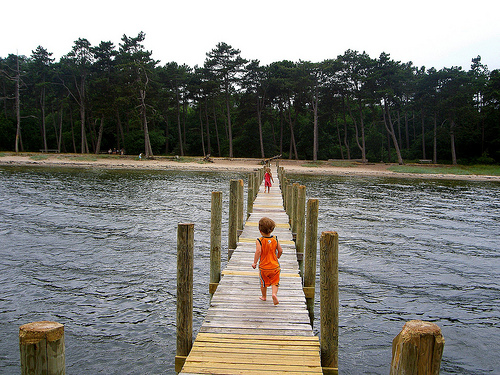

In [ ]:
Image.open('../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/'+image_names_validation[0])

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open('../input/neuralsntua-image-captioning/flickr30k-images-ecemod/image_dir/'+image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
max_bleu_score = -1

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

### Eκπαίδευση με Random και Greedy μεθόδους

Τρέξαμε εκτός από την beam_search και αρκετές φορές τις μεθόδους πρόβλεψης random και greedy , οι οποίες δεν έδιναν καλύτερα αποτελέσματα από την beam search. Συγκεκριμένα για 30 epochs το μέγιστο corpus bleu score που παρατηρήσαμε κατα το training ήταν 0.31 για την random και 0.43 για την greedy.   

### Εκπαίδευση με Beam Search 70 epochs 

Epoch 1 Batch 0 Loss 5.7997
Epoch 1 Batch 100 Loss 2.7708
Epoch 1 Batch 200 Loss 2.3431
Epoch 1 Batch 300 Loss 2.3194
Epoch 1 Batch 400 Loss 2.2817
Epoch 1 Batch 500 Loss 2.3059
Epoch 1 Batch 600 Loss 2.1238
Epoch 1 Batch 700 Loss 2.2553
Epoch 1 Batch 800 Loss 2.2507
Epoch 1 Batch 900 Loss 1.9842
Epoch 1 Batch 1000 Loss 2.2478
Epoch 1 Batch 1100 Loss 2.0799
Epoch 1 Batch 1200 Loss 2.0231
Epoch 1 Batch 1300 Loss 2.2262
Epoch 1 Batch 1400 Loss 1.9238
Epoch 1 Batch 1500 Loss 1.9706


100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Mean sentence bleu score: 0.042
Max sentence bleu score: 0.135
Corpus bleu score: 0.041
----------------------------------------------------

Real Caption: [['a', 'man', 'in', 'a', 'fur', 'hat', 'is', 'carrying', 'a', 'drum', 'that', 'says', '[UNK]', '.'], ['a', 'man', 'in', 'a', 'fuzzy', 'hat', 'is', 'holding', 'a', 'large', 'bass', 'drum', '.'], ['a', 'man', 'is', 'playing', 'a', 'drum', 'in', 'a', 'marching', 'band', '.'], ['a', 'bass', 'drummer', 'marches', 'in', 'a', 'band', 'formation', '.']]
----------------------------------------------------

Predicted Caption: ['in', 'the', 'other', 'other', 'people', 'walk', 'down', 'the', 'middle', 'eastern', 'city', 'streets', 'in', 'the', 'other', 'other', 'people', 'walk', 'down', 'the', 'middle']
----------------------------------------------------



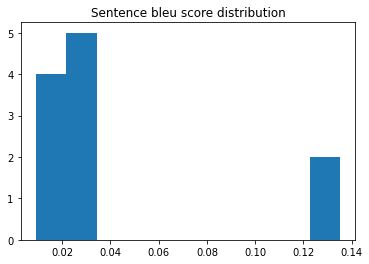

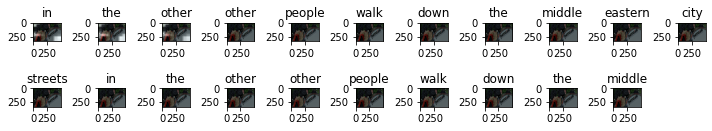

Epoch 1 Loss 2.226695
Time taken for 1 epoch 363.32 sec

Epoch 2 Batch 0 Loss 1.8770
Epoch 2 Batch 100 Loss 2.1168
Epoch 2 Batch 200 Loss 2.0043
Epoch 2 Batch 300 Loss 2.1084
Epoch 2 Batch 400 Loss 1.8896
Epoch 2 Batch 500 Loss 1.9217
Epoch 2 Batch 600 Loss 1.8141
Epoch 2 Batch 700 Loss 1.8701
Epoch 2 Batch 800 Loss 1.9442
Epoch 2 Batch 900 Loss 2.2053
Epoch 2 Batch 1000 Loss 1.8629
Epoch 2 Batch 1100 Loss 1.7098
Epoch 2 Batch 1200 Loss 1.7697
Epoch 2 Batch 1300 Loss 1.8964
Epoch 2 Batch 1400 Loss 1.9729
Epoch 2 Batch 1500 Loss 1.8924
Epoch 2 Loss 1.952158
Time taken for 1 epoch 290.67 sec

Epoch 3 Batch 0 Loss 1.7447
Epoch 3 Batch 100 Loss 1.7327
Epoch 3 Batch 200 Loss 1.9500
Epoch 3 Batch 300 Loss 1.9050
Epoch 3 Batch 400 Loss 2.0150
Epoch 3 Batch 500 Loss 1.8232
Epoch 3 Batch 600 Loss 1.9673
Epoch 3 Batch 700 Loss 1.9360
Epoch 3 Batch 800 Loss 1.8212
Epoch 3 Batch 900 Loss 1.7740
Epoch 3 Batch 1000 Loss 1.9879
Epoch 3 Batch 1100 Loss 1.9833
Epoch 3 Batch 1200 Loss 1.8786
Epoch 3 Bat

100%|██████████| 11/11 [00:26<00:00,  2.45s/it]


Mean sentence bleu score: 0.043
Max sentence bleu score: 0.302
Corpus bleu score: 0.045
----------------------------------------------------

Real Caption: [['a', 'man', 'stands', 'in', 'front', 'of', 'a', 'board', 'covered', 'in', 'papers', 'while', 'giving', 'a', 'speech', 'to', 'a', 'crowd', '.'], ['a', 'man', 'in', 'a', 'light', 'blueish', ',', 'collared', 'shirt', 'is', 'talking', 'to', 'a', 'group', 'of', 'people', '.'], ['a', 'man', 'in', 'khakis', 'and', 'a', 'blue', 'shirt', 'speaks', 'into', 'a', 'microphone', 'before', 'a', 'group', '.'], ['a', 'man', 'in', 'casual', 'clothes', 'is', 'speaking', 'in', 'front', 'of', 'people', '.'], ['a', 'public', 'speaker', 'discussing', 'what', 'needs', 'to', 'be', 'changed', '.']]
----------------------------------------------------

Predicted Caption: ['a', 'woman', 'and', 'two', 'young', 'boy', 'and', 'a', 'woman', 'and', 'two', 'a', 'woman', 'and', 'two', 'a', 'woman', 'and', 'two', 'a', 'woman']
---------------------------------------

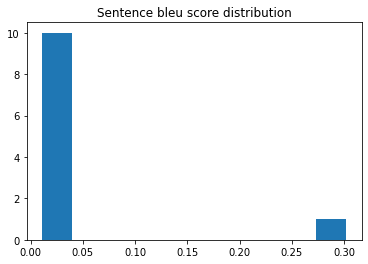

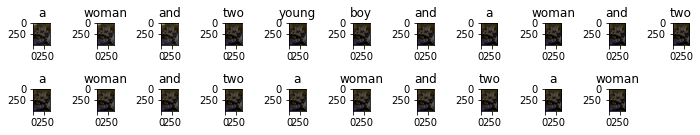

Epoch 4 Loss 1.805715
Time taken for 1 epoch 323.82 sec

Epoch 5 Batch 0 Loss 1.9147
Epoch 5 Batch 100 Loss 1.6955
Epoch 5 Batch 200 Loss 1.8711
Epoch 5 Batch 300 Loss 1.9388
Epoch 5 Batch 400 Loss 1.7886
Epoch 5 Batch 500 Loss 1.7858
Epoch 5 Batch 600 Loss 1.8813
Epoch 5 Batch 700 Loss 1.6961
Epoch 5 Batch 800 Loss 1.9144
Epoch 5 Batch 900 Loss 1.8677
Epoch 5 Batch 1000 Loss 1.7251
Epoch 5 Batch 1100 Loss 1.7523
Epoch 5 Batch 1200 Loss 1.9564
Epoch 5 Batch 1300 Loss 1.7072
Epoch 5 Batch 1400 Loss 1.5591
Epoch 5 Batch 1500 Loss 1.6779
Epoch 5 Loss 1.762785
Time taken for 1 epoch 299.73 sec

Epoch 6 Batch 0 Loss 1.5301
Epoch 6 Batch 100 Loss 1.8063
Epoch 6 Batch 200 Loss 1.7133
Epoch 6 Batch 300 Loss 1.7069
Epoch 6 Batch 400 Loss 1.7348
Epoch 6 Batch 500 Loss 1.6359
Epoch 6 Batch 600 Loss 1.7872
Epoch 6 Batch 700 Loss 1.6889
Epoch 6 Batch 800 Loss 1.7044
Epoch 6 Batch 900 Loss 1.8104
Epoch 6 Batch 1000 Loss 1.6798
Epoch 6 Batch 1100 Loss 1.7399
Epoch 6 Batch 1200 Loss 1.7122
Epoch 6 Bat

100%|██████████| 11/11 [00:26<00:00,  2.43s/it]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean sentence bleu score: 0.029
Max sentence bleu score: 0.112
Corpus bleu score: 0.098
----------------------------------------------------

Real Caption: [['two', 'women', 'are', 'standing', 'around', 'a', 'covered', 'table', 'outside', 'surrounded', 'by', 'beautiful', 'flowers', '.'], ['a', 'red-haired', 'lady', 'reveals', '[UNK]', 'food', 'from', 'underneath', 'a', 'blanket', '.'], ['an', 'older', 'woman', 'is', 'placing', 'a', 'cloth', 'over', 'items', 'on', 'a', 'table', '.'], ['a', 'woman', 'is', 'laying', 'a', 'blanket', 'over', 'fresh', 'produce', 'outside', '.']]
----------------------------------------------------

Predicted Caption: ['a', 'blue', 'jeans', 'and', 'a', 'blue', 'jeans', 'and', 'a', 'blue', 'jeans', 'and', 'a', 'blue', 'jeans', 'and', 'a', 'blue', 'jeans', 'and', 'a']
----------------------------------------------------



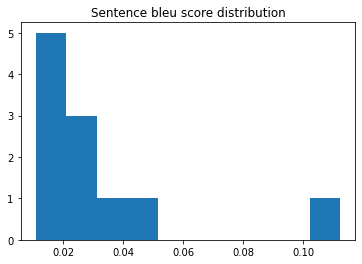

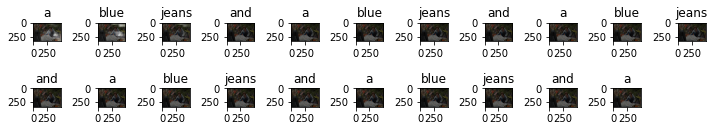

Epoch 7 Loss 1.699082
Time taken for 1 epoch 345.38 sec

Epoch 8 Batch 0 Loss 1.6575
Epoch 8 Batch 100 Loss 1.6967
Epoch 8 Batch 200 Loss 1.7404
Epoch 8 Batch 300 Loss 1.6637
Epoch 8 Batch 400 Loss 1.6934
Epoch 8 Batch 500 Loss 1.7275
Epoch 8 Batch 600 Loss 1.5620
Epoch 8 Batch 700 Loss 1.6567
Epoch 8 Batch 800 Loss 1.5818
Epoch 8 Batch 900 Loss 1.5675
Epoch 8 Batch 1000 Loss 1.6504
Epoch 8 Batch 1100 Loss 1.5528
Epoch 8 Batch 1200 Loss 1.7337
Epoch 8 Batch 1300 Loss 1.5883
Epoch 8 Batch 1400 Loss 1.5799
Epoch 8 Batch 1500 Loss 1.7147
Epoch 8 Loss 1.674320
Time taken for 1 epoch 284.60 sec

Epoch 9 Batch 0 Loss 1.5916
Epoch 9 Batch 100 Loss 1.7858
Epoch 9 Batch 200 Loss 1.6041
Epoch 9 Batch 300 Loss 1.6676
Epoch 9 Batch 400 Loss 1.6398
Epoch 9 Batch 500 Loss 1.6028
Epoch 9 Batch 600 Loss 1.7448
Epoch 9 Batch 700 Loss 1.6536
Epoch 9 Batch 800 Loss 1.6709
Epoch 9 Batch 900 Loss 1.5806
Epoch 9 Batch 1000 Loss 1.6087
Epoch 9 Batch 1100 Loss 1.6695
Epoch 9 Batch 1200 Loss 1.6664
Epoch 9 Bat

100%|██████████| 11/11 [00:27<00:00,  2.47s/it]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean sentence bleu score: 0.015
Max sentence bleu score: 0.027
Corpus bleu score: 0.277
----------------------------------------------------

Real Caption: [['a', 'baby', 'girl', 'in', 'a', 'light', 'blue', 'and', 'pink', 'dress', 'leaning', 'on', 'a', 'stone', 'platform', 'outdoors', '.'], ['a', 'baby', 'girl', 'in', 'a', 'blue', 'dress', 'is', 'standing', 'on', 'a', 'rock', 'wall', 'near', 'a', 'tree', '.'], ['this', 'is', 'baby', ',', 'dressed', 'in', 'blue', ',', 'standing', 'barefoot', 'on', 'a', 'stone', '.'], ['a', 'toddler', 'in', 'a', 'blue', 'dress', 'holding', 'himself', 'up', 'on', 'a', 'rock', '.'], ['a', 'pretty', 'baby', 'girl', 'posing', 'on', 'a', 'rock', 'wall']]
----------------------------------------------------

Predicted Caption: ['and', 'black', 'shorts', 'is', 'smearing', 'a', 'blue', 'jeans', 'is', 'smearing', 'a', 'blue', 'jeans', 'is', 'smearing', 'a', 'blue', 'jeans', 'is', 'smearing', 'a']
----------------------------------------------------



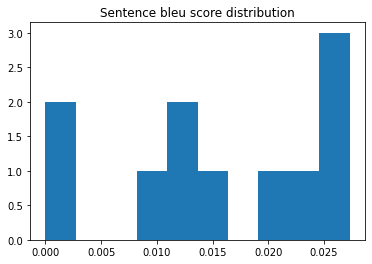

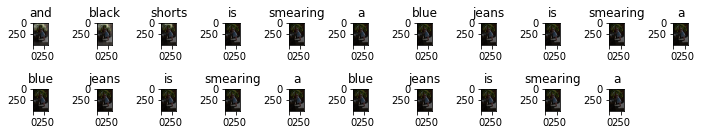

Epoch 10 Loss 1.631345
Time taken for 1 epoch 328.17 sec

Epoch 11 Batch 0 Loss 1.6935
Epoch 11 Batch 100 Loss 1.5931
Epoch 11 Batch 200 Loss 1.6101
Epoch 11 Batch 300 Loss 1.5280
Epoch 11 Batch 400 Loss 1.6210
Epoch 11 Batch 500 Loss 1.6209
Epoch 11 Batch 600 Loss 1.6125
Epoch 11 Batch 700 Loss 1.5556
Epoch 11 Batch 800 Loss 1.6663
Epoch 11 Batch 900 Loss 1.6686
Epoch 11 Batch 1000 Loss 1.4699
Epoch 11 Batch 1100 Loss 1.6635
Epoch 11 Batch 1200 Loss 1.5114
Epoch 11 Batch 1300 Loss 1.5524
Epoch 11 Batch 1400 Loss 1.5340
Epoch 11 Batch 1500 Loss 1.5747
Epoch 11 Loss 1.613419
Time taken for 1 epoch 296.26 sec

Epoch 12 Batch 0 Loss 1.6659
Epoch 12 Batch 100 Loss 1.6079
Epoch 12 Batch 200 Loss 1.5298
Epoch 12 Batch 300 Loss 1.6164
Epoch 12 Batch 400 Loss 1.6855
Epoch 12 Batch 500 Loss 1.5761
Epoch 12 Batch 600 Loss 1.4509
Epoch 12 Batch 700 Loss 1.6241
Epoch 12 Batch 800 Loss 1.7245
Epoch 12 Batch 900 Loss 1.5608
Epoch 12 Batch 1000 Loss 1.6934
Epoch 12 Batch 1100 Loss 1.6571
Epoch 12 Bat

100%|██████████| 11/11 [00:26<00:00,  2.44s/it]


Mean sentence bleu score: 0.022
Max sentence bleu score: 0.054
Corpus bleu score: 0.086
----------------------------------------------------

Real Caption: [['a', 'young', 'girl', 'in', 'a', 'hotel', 'lobby', 'is', 'balancing', 'a', 'game', 'of', 'wooden', 'blocks', 'on', 'a', 'table', '.'], ['asian', 'girl', 'playing', 'jenga', '[UNK]', 'that', 'the', 'pieces', 'will', 'fall', 'over', '.'], ['a', 'lady', 'is', 'playing', 'jenga', ',', 'hoping', 'the', 'tower', 'does', "n't", 'fall', '.'], ['young', 'woman', 'trying', 'to', 'keep', 'the', 'jenga', 'tower', '[UNK]', '.'], ['a', 'woman', 'with', 'glasses', 'is', 'playing', 'jenga']]
----------------------------------------------------

Predicted Caption: ['a', 'woman', 'has', 'climbed', 'a', 'blue', 'jeans', 'a', 'woman', 'has', 'climbed', 'a', 'woman', 'has', 'climbed', 'a', 'blue', 'jeans', 'at', 'a', 'woman']
----------------------------------------------------



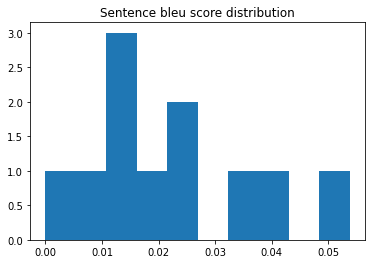

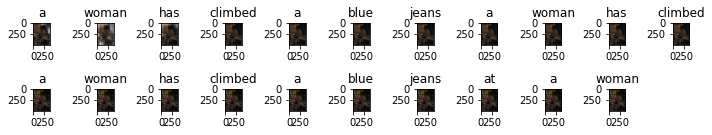

Epoch 13 Loss 1.581254
Time taken for 1 epoch 325.87 sec

Epoch 14 Batch 0 Loss 1.6385
Epoch 14 Batch 100 Loss 1.5935
Epoch 14 Batch 200 Loss 1.5248
Epoch 14 Batch 300 Loss 1.5900
Epoch 14 Batch 400 Loss 1.5865
Epoch 14 Batch 500 Loss 1.6625
Epoch 14 Batch 600 Loss 1.6134
Epoch 14 Batch 700 Loss 1.6237
Epoch 14 Batch 800 Loss 1.6559
Epoch 14 Batch 900 Loss 1.6424
Epoch 14 Batch 1000 Loss 1.5132
Epoch 14 Batch 1100 Loss 1.5213
Epoch 14 Batch 1200 Loss 1.4521
Epoch 14 Batch 1300 Loss 1.6777
Epoch 14 Batch 1400 Loss 1.4394
Epoch 14 Batch 1500 Loss 1.6967
Epoch 14 Loss 1.566995
Time taken for 1 epoch 315.91 sec

Epoch 15 Batch 0 Loss 1.5760
Epoch 15 Batch 100 Loss 1.5987
Epoch 15 Batch 200 Loss 1.6190
Epoch 15 Batch 300 Loss 1.4594
Epoch 15 Batch 400 Loss 1.4892
Epoch 15 Batch 500 Loss 1.5168
Epoch 15 Batch 600 Loss 1.6020
Epoch 15 Batch 700 Loss 1.5646
Epoch 15 Batch 800 Loss 1.6803
Epoch 15 Batch 900 Loss 1.6155
Epoch 15 Batch 1000 Loss 1.5939
Epoch 15 Batch 1100 Loss 1.4759
Epoch 15 Bat

100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Mean sentence bleu score: 0.014
Max sentence bleu score: 0.030
Corpus bleu score: 0.153
----------------------------------------------------

Real Caption: [['a', 'street', 'scene', 'with', 'several', 'archways', 'and', 'a', 'two', 'towers', 'in', 'the', 'background', '.'], ['people', 'are', 'walking', 'across', 'the', 'street', 'of', 'a', 'city', '.'], ['a', 'photographer', "'s", 'view', 'of', 'a', 'busy', 'street', '.'], ['people', 'are', 'walking', 'in', 'a', 'sunny', 'plaza', '.'], ['tourists', 'mingle', 'on', 'a', 'street', '.']]
----------------------------------------------------

Predicted Caption: ['a', 'cast', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast', 'a', 'cast']
----------------------------------------------------



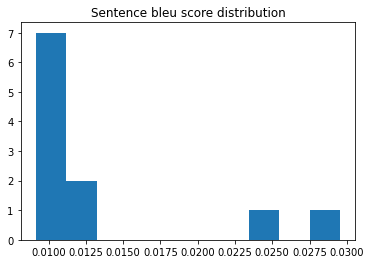

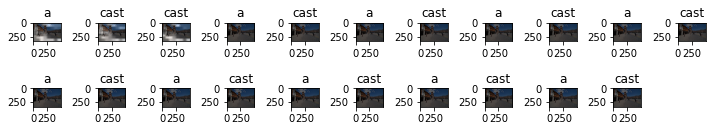

Epoch 16 Loss 1.541288
Time taken for 1 epoch 341.77 sec

Epoch 17 Batch 0 Loss 1.6096
Epoch 17 Batch 100 Loss 1.5692
Epoch 17 Batch 200 Loss 1.5493
Epoch 17 Batch 300 Loss 1.5673
Epoch 17 Batch 400 Loss 1.5691
Epoch 17 Batch 500 Loss 1.5831
Epoch 17 Batch 600 Loss 1.4877
Epoch 17 Batch 700 Loss 1.4955
Epoch 17 Batch 800 Loss 1.5448
Epoch 17 Batch 900 Loss 1.4931
Epoch 17 Batch 1000 Loss 1.6655
Epoch 17 Batch 1100 Loss 1.5653
Epoch 17 Batch 1200 Loss 1.5645
Epoch 17 Batch 1300 Loss 1.4985
Epoch 17 Batch 1400 Loss 1.4245
Epoch 17 Batch 1500 Loss 1.6032
Epoch 17 Loss 1.529684
Time taken for 1 epoch 296.55 sec

Epoch 18 Batch 0 Loss 1.4243
Epoch 18 Batch 100 Loss 1.5010
Epoch 18 Batch 200 Loss 1.5084
Epoch 18 Batch 300 Loss 1.5929
Epoch 18 Batch 400 Loss 1.4794
Epoch 18 Batch 500 Loss 1.5944
Epoch 18 Batch 600 Loss 1.5422
Epoch 18 Batch 700 Loss 1.4236
Epoch 18 Batch 800 Loss 1.3990
Epoch 18 Batch 900 Loss 1.4824
Epoch 18 Batch 1000 Loss 1.4592
Epoch 18 Batch 1100 Loss 1.6614
Epoch 18 Bat

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Mean sentence bleu score: 0.015
Max sentence bleu score: 0.030
Corpus bleu score: 0.292
----------------------------------------------------

Real Caption: [['four', 'women', 'competing', 'in', 'beach', 'volleyball', 'beside', 'a', 'large', 'body', 'of', 'water', '.'], ['a', 'group', 'of', 'women', 'wearing', 'bikinis', 'are', 'playing', 'beach', 'volleyball', '.'], ['four', 'young', 'women', 'wearing', 'bikinis', 'are', 'playing', 'beach', 'volleyball'], ['women', 'in', 'bikinis', 'play', 'beach', 'volleyball', 'by', 'the', 'waterside', '.'], ['girls', 'in', 'bikinis', 'playing', 'volleyball', 'on', 'the', 'beach', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



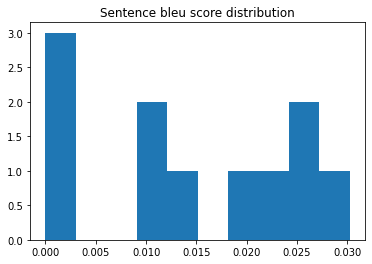

<Figure size 720x720 with 0 Axes>

Epoch 19 Loss 1.509126
Time taken for 1 epoch 357.64 sec

Epoch 20 Batch 0 Loss 1.5123
Epoch 20 Batch 100 Loss 1.4531
Epoch 20 Batch 200 Loss 1.4682
Epoch 20 Batch 300 Loss 1.4670
Epoch 20 Batch 400 Loss 1.5553
Epoch 20 Batch 500 Loss 1.5464
Epoch 20 Batch 600 Loss 1.4798
Epoch 20 Batch 700 Loss 1.4305
Epoch 20 Batch 800 Loss 1.4584
Epoch 20 Batch 900 Loss 1.5455
Epoch 20 Batch 1000 Loss 1.4371
Epoch 20 Batch 1100 Loss 1.3881
Epoch 20 Batch 1200 Loss 1.5801
Epoch 20 Batch 1300 Loss 1.5006
Epoch 20 Batch 1400 Loss 1.3658
Epoch 20 Batch 1500 Loss 1.5663
Epoch 20 Loss 1.499405
Time taken for 1 epoch 306.72 sec

Epoch 21 Batch 0 Loss 1.5307
Epoch 21 Batch 100 Loss 1.5390
Epoch 21 Batch 200 Loss 1.5704
Epoch 21 Batch 300 Loss 1.5424
Epoch 21 Batch 400 Loss 1.4338
Epoch 21 Batch 500 Loss 1.3189
Epoch 21 Batch 600 Loss 1.4775
Epoch 21 Batch 700 Loss 1.5622
Epoch 21 Batch 800 Loss 1.5108
Epoch 21 Batch 900 Loss 1.5058
Epoch 21 Batch 1000 Loss 1.3310
Epoch 21 Batch 1100 Loss 1.4640
Epoch 21 Bat

100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Mean sentence bleu score: 0.017
Max sentence bleu score: 0.043
Corpus bleu score: 0.216
----------------------------------------------------

Real Caption: [['a', 'small', 'white', 'and', 'brown', 'dog', 'is', 'jumping', 'over', 'a', 'horizontal', 'pole', '.'], ['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'over', 'a', 'yellow', 'and', 'red', 'pole', '.'], ['a', 'brown', 'and', 'white', 'dog', 'jumping', 'over', 'a', 'red', 'and', 'yellow', 'pole'], ['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'a', 'red', 'and', 'yellow', 'pole', '.'], ['a', 'brown', 'and', 'white', 'dog', 'is', 'jumping', 'over', 'an', 'obstacle']]
----------------------------------------------------

Predicted Caption: ['in', 'america', 'cabin', 'a', 'fake', 'ice', 'skater', 'done', 'somewhere', 'somewhere', 'done', 'jumped', 'hot', 'hot', 'air', 'market', 'display', 'sail', 'in', 'america', 'looms']
----------------------------------------------------



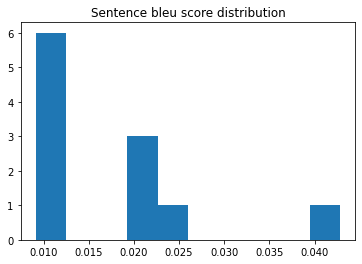

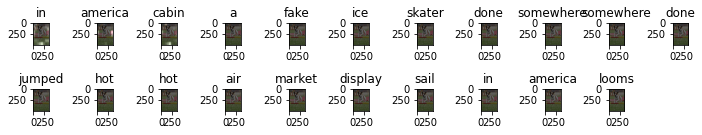

Epoch 22 Loss 1.481537
Time taken for 1 epoch 337.00 sec

Epoch 23 Batch 0 Loss 1.4279
Epoch 23 Batch 100 Loss 1.4211
Epoch 23 Batch 200 Loss 1.3796
Epoch 23 Batch 300 Loss 1.5307
Epoch 23 Batch 400 Loss 1.4180
Epoch 23 Batch 500 Loss 1.4669
Epoch 23 Batch 600 Loss 1.4868
Epoch 23 Batch 700 Loss 1.3286
Epoch 23 Batch 800 Loss 1.4499
Epoch 23 Batch 900 Loss 1.4330
Epoch 23 Batch 1000 Loss 1.4786
Epoch 23 Batch 1100 Loss 1.5072
Epoch 23 Batch 1200 Loss 1.4456
Epoch 23 Batch 1300 Loss 1.3553
Epoch 23 Batch 1400 Loss 1.5951
Epoch 23 Batch 1500 Loss 1.4375
Epoch 23 Loss 1.473349
Time taken for 1 epoch 294.04 sec

Epoch 24 Batch 0 Loss 1.7056
Epoch 24 Batch 100 Loss 1.4327
Epoch 24 Batch 200 Loss 1.4693
Epoch 24 Batch 300 Loss 1.4501
Epoch 24 Batch 400 Loss 1.5658
Epoch 24 Batch 500 Loss 1.4141
Epoch 24 Batch 600 Loss 1.5968
Epoch 24 Batch 700 Loss 1.4634
Epoch 24 Batch 800 Loss 1.3471
Epoch 24 Batch 900 Loss 1.4599
Epoch 24 Batch 1000 Loss 1.3875
Epoch 24 Batch 1100 Loss 1.4555
Epoch 24 Bat

100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Mean sentence bleu score: 0.009
Max sentence bleu score: 0.019
Corpus bleu score: 0.129
----------------------------------------------------

Real Caption: [['five', 'people', 'outside', 'in', 'the', 'river', 'working', 'with', 'their', 'nets', 'to', 'catch', 'fish', '.'], ['three', 'women', 'and', 'two', 'men', 'are', 'using', '[UNK]', 'nets', 'in', 'a', 'stream', '.'], ['five', 'asian', 'people', 'in', 'a', 'river', 'holding', 'plants', 'and', 'nets', '.'], ['5', 'people', 'stand', 'in', 'a', 'river', 'with', 'nets', 'wearing', 'hats', '.'], ['these', 'farmers', 'are', 'taking', 'a', 'break', 'from', 'work', '.']]
----------------------------------------------------

Predicted Caption: ['an', 'elementary', 'school', 'age', 'had', 'sleeps', 'on', 'scooters', 'hammock', 'beside', 'a', 'strange', 'a', 'turkey', 'repairing', 'guitars', 'pauses', 'it', 'needs', 'guide', 'them']
----------------------------------------------------



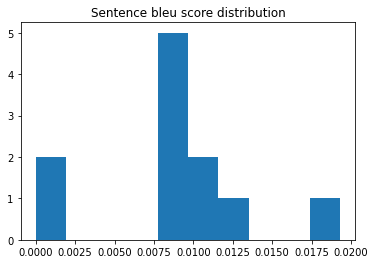

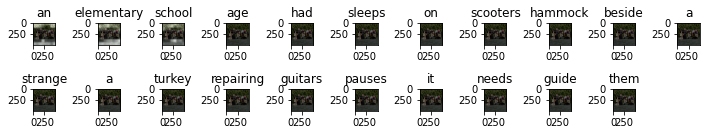

Epoch 25 Loss 1.458670
Time taken for 1 epoch 329.94 sec

Epoch 26 Batch 0 Loss 1.5243
Epoch 26 Batch 100 Loss 1.3909
Epoch 26 Batch 200 Loss 1.4901
Epoch 26 Batch 300 Loss 1.3639
Epoch 26 Batch 400 Loss 1.4310
Epoch 26 Batch 500 Loss 1.3860
Epoch 26 Batch 600 Loss 1.3447
Epoch 26 Batch 700 Loss 1.4138
Epoch 26 Batch 800 Loss 1.4694
Epoch 26 Batch 900 Loss 1.3021
Epoch 26 Batch 1000 Loss 1.4255
Epoch 26 Batch 1100 Loss 1.4845
Epoch 26 Batch 1200 Loss 1.3385
Epoch 26 Batch 1300 Loss 1.4283
Epoch 26 Batch 1400 Loss 1.4801
Epoch 26 Batch 1500 Loss 1.6106
Epoch 26 Loss 1.452288
Time taken for 1 epoch 278.41 sec

Epoch 27 Batch 0 Loss 1.3653
Epoch 27 Batch 100 Loss 1.3904
Epoch 27 Batch 200 Loss 1.3295
Epoch 27 Batch 300 Loss 1.4418
Epoch 27 Batch 400 Loss 1.4651
Epoch 27 Batch 500 Loss 1.5851
Epoch 27 Batch 600 Loss 1.4184
Epoch 27 Batch 700 Loss 1.4483
Epoch 27 Batch 800 Loss 1.4261
Epoch 27 Batch 900 Loss 1.3740
Epoch 27 Batch 1000 Loss 1.3788
Epoch 27 Batch 1100 Loss 1.3953
Epoch 27 Bat

100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Mean sentence bleu score: 0.020
Max sentence bleu score: 0.033
Corpus bleu score: 0.274
----------------------------------------------------

Real Caption: [['a', 'caramel', 'colored', 'dog', 'sits', 'in', 'front', 'of', 'trees', 'looking', 'forward', '.'], ['a', 'brown', 'dog', 'with', 'a', 'black', 'collar', 'stands', 'next', 'to', 'a', 'bush', '.'], ['a', 'sad', 'looking', 'dog', 'sitting', 'next', 'to', 'shrubs', '.'], ['the', 'brown', 'dog', 'is', 'wearing', 'a', 'black', 'collar', '.']]
----------------------------------------------------

Predicted Caption: ['.', 'sale', 'in', 'the', 'catcher', 'texas', 'mooring']
----------------------------------------------------



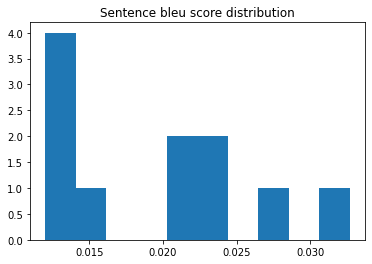

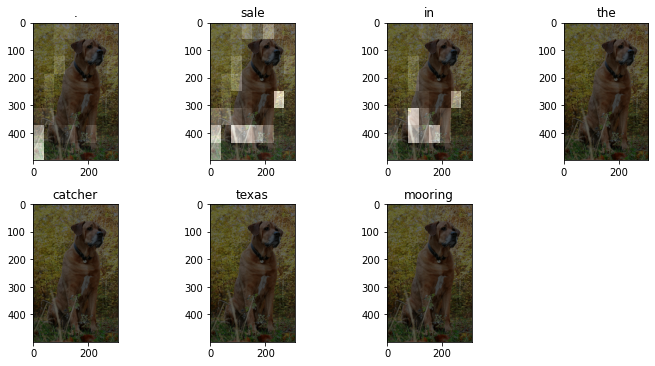

Epoch 28 Loss 1.440120
Time taken for 1 epoch 325.46 sec

Epoch 29 Batch 0 Loss 1.4898
Epoch 29 Batch 100 Loss 1.4648
Epoch 29 Batch 200 Loss 1.4300
Epoch 29 Batch 300 Loss 1.4792
Epoch 29 Batch 400 Loss 1.4055
Epoch 29 Batch 500 Loss 1.3953
Epoch 29 Batch 600 Loss 1.4085
Epoch 29 Batch 700 Loss 1.2716
Epoch 29 Batch 800 Loss 1.4531
Epoch 29 Batch 900 Loss 1.3352
Epoch 29 Batch 1000 Loss 1.4738
Epoch 29 Batch 1100 Loss 1.5260
Epoch 29 Batch 1200 Loss 1.4088
Epoch 29 Batch 1300 Loss 1.5362
Epoch 29 Batch 1400 Loss 1.4493
Epoch 29 Batch 1500 Loss 1.5725
Epoch 29 Loss 1.434055
Time taken for 1 epoch 307.95 sec

Epoch 30 Batch 0 Loss 1.5946
Epoch 30 Batch 100 Loss 1.4426
Epoch 30 Batch 200 Loss 1.4463
Epoch 30 Batch 300 Loss 1.4593
Epoch 30 Batch 400 Loss 1.4187
Epoch 30 Batch 500 Loss 1.3818
Epoch 30 Batch 600 Loss 1.4106
Epoch 30 Batch 700 Loss 1.3596
Epoch 30 Batch 800 Loss 1.3912
Epoch 30 Batch 900 Loss 1.3736
Epoch 30 Batch 1000 Loss 1.4034
Epoch 30 Batch 1100 Loss 1.4546
Epoch 30 Bat

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Mean sentence bleu score: 0.010
Max sentence bleu score: 0.019
Corpus bleu score: 0.184
----------------------------------------------------

Real Caption: [['four', 'women', 'competing', 'in', 'beach', 'volleyball', 'beside', 'a', 'large', 'body', 'of', 'water', '.'], ['a', 'group', 'of', 'women', 'wearing', 'bikinis', 'are', 'playing', 'beach', 'volleyball', '.'], ['four', 'young', 'women', 'wearing', 'bikinis', 'are', 'playing', 'beach', 'volleyball'], ['women', 'in', 'bikinis', 'play', 'beach', 'volleyball', 'by', 'the', 'waterside', '.'], ['girls', 'in', 'bikinis', 'playing', 'volleyball', 'on', 'the', 'beach', '.']]
----------------------------------------------------

Predicted Caption: ['.', 'sale', 'in', 'winter', 'market', 'flyer', 'parachute', 'in', 'winter', 'marketplace', 'approaches', 'college', 'cuts', 'them', 'sail', 'on', 'valley', 'countryside', '.', 'sale', 'in']
----------------------------------------------------



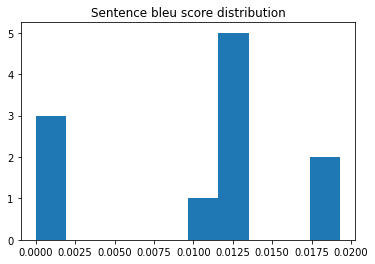

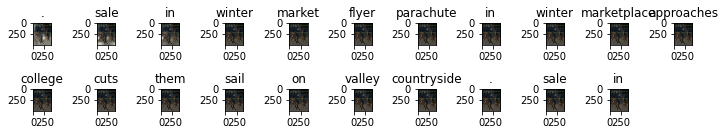

Epoch 31 Loss 1.424395
Time taken for 1 epoch 317.76 sec

Epoch 32 Batch 0 Loss 1.4030
Epoch 32 Batch 100 Loss 1.4038
Epoch 32 Batch 200 Loss 1.3397
Epoch 32 Batch 300 Loss 1.4638
Epoch 32 Batch 400 Loss 1.5420
Epoch 32 Batch 500 Loss 1.3622
Epoch 32 Batch 600 Loss 1.4631
Epoch 32 Batch 700 Loss 1.3751
Epoch 32 Batch 800 Loss 1.5297
Epoch 32 Batch 900 Loss 1.3831
Epoch 32 Batch 1000 Loss 1.4518
Epoch 32 Batch 1100 Loss 1.4373
Epoch 32 Batch 1200 Loss 1.4623
Epoch 32 Batch 1300 Loss 1.3203
Epoch 32 Batch 1400 Loss 1.4953
Epoch 32 Batch 1500 Loss 1.3426
Epoch 32 Loss 1.419335
Time taken for 1 epoch 287.14 sec

Epoch 33 Batch 0 Loss 1.5207
Epoch 33 Batch 100 Loss 1.4618
Epoch 33 Batch 200 Loss 1.3861
Epoch 33 Batch 300 Loss 1.3800
Epoch 33 Batch 400 Loss 1.3666
Epoch 33 Batch 500 Loss 1.4533
Epoch 33 Batch 600 Loss 1.4278
Epoch 33 Batch 700 Loss 1.4066
Epoch 33 Batch 800 Loss 1.3681
Epoch 33 Batch 900 Loss 1.4488
Epoch 33 Batch 1000 Loss 1.4051
Epoch 33 Batch 1100 Loss 1.3770
Epoch 33 Bat

100%|██████████| 11/11 [00:25<00:00,  2.32s/it]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean sentence bleu score: 0.008
Max sentence bleu score: 0.012
Corpus bleu score: 0.505
----------------------------------------------------

Real Caption: [['the', 'woman', 'is', 'dressed', 'in', 'all', 'white', 'swinging', 'a', 'tennis', 'racket', '.'], ['a', 'woman', 'intensely', 'playing', 'tennis', 'in', 'an', '[UNK]', 'outfit', '.'], ['the', 'tennis', 'player', 'dressed', 'in', 'white', 'swings', 'the', 'racket', '.'], ['a', 'woman', 'swinging', 'a', 'tennis', 'racket', 'on', 'the', 'court', '.'], ['a', 'female', 'tennis', 'player', 'swings', 'for', 'the', 'ball', '.']]
----------------------------------------------------

Predicted Caption: ['in', 'winter', 'department', 'lounge', 'shining', 'plants', 'life', 'winter', 'grounds', 'put', 'bite', 'teeth', 'bared', 'village', 'played', 'lacrosse', 'numbered', 'can', 'be', 'hit', 'licks']
----------------------------------------------------



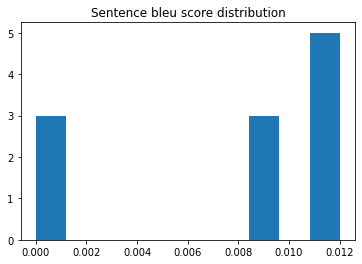

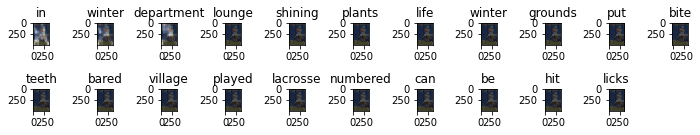

Epoch 34 Loss 1.410298
Time taken for 1 epoch 322.60 sec

Epoch 35 Batch 0 Loss 1.4653
Epoch 35 Batch 100 Loss 1.3392
Epoch 35 Batch 200 Loss 1.5140
Epoch 35 Batch 300 Loss 1.3299
Epoch 35 Batch 400 Loss 1.3893
Epoch 35 Batch 500 Loss 1.4592
Epoch 35 Batch 600 Loss 1.3300
Epoch 35 Batch 700 Loss 1.4073
Epoch 35 Batch 800 Loss 1.4720
Epoch 35 Batch 900 Loss 1.3799
Epoch 35 Batch 1000 Loss 1.3353
Epoch 35 Batch 1100 Loss 1.3958
Epoch 35 Batch 1200 Loss 1.3982
Epoch 35 Batch 1300 Loss 1.5778
Epoch 35 Batch 1400 Loss 1.4244
Epoch 35 Batch 1500 Loss 1.3664
Epoch 35 Loss 1.405981
Time taken for 1 epoch 299.33 sec

Epoch 36 Batch 0 Loss 1.4019
Epoch 36 Batch 100 Loss 1.3511
Epoch 36 Batch 200 Loss 1.2720
Epoch 36 Batch 300 Loss 1.3398
Epoch 36 Batch 400 Loss 1.4707
Epoch 36 Batch 500 Loss 1.3750
Epoch 36 Batch 600 Loss 1.4301
Epoch 36 Batch 700 Loss 1.4206
Epoch 36 Batch 800 Loss 1.4474
Epoch 36 Batch 900 Loss 1.3000
Epoch 36 Batch 1000 Loss 1.3649
Epoch 36 Batch 1100 Loss 1.5471
Epoch 36 Bat

100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Mean sentence bleu score: 0.011
Max sentence bleu score: 0.023
Corpus bleu score: 0.195
----------------------------------------------------

Real Caption: [['an', 'older', 'woman', 'dressed', 'in', 'an', '[UNK]', 'yellow', 'shirt', 'and', 'blue', 'plaid', 'skirt', 'is', 'sitting', 'on', 'the', 'ground', 'next', 'to', 'two'], ['a', 'black', 'woman', 'sitting', 'in', 'the', 'dirt', 'next', 'to', 'two', 'buckets', 'of', 'rock', '.'], ['an', 'old', 'woman', 'sitting', 'on', 'the', 'ground', 'next', 'to', 'two', 'pails', '.'], ['a', 'woman', 'sits', 'next', 'to', 'a', 'bucket', 'of', 'collected', 'clams', '.'], ['a', 'woman', 'sitting', 'in', 'the', 'dirt', '.']]
----------------------------------------------------

Predicted Caption: ['a', 'few', 'racing', '2', 'flame', 'paints', 'a', 'woman', 'is', 'aiming', 'his', 'fog', 'storm', 'trooper', 'during', 'winter', 'butterfly', 'irish', 'those', 'fell', 'tiny']
----------------------------------------------------



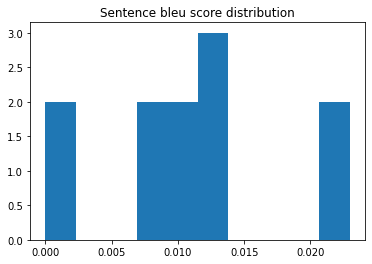

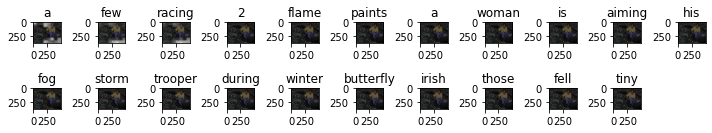

Epoch 37 Loss 1.398370
Time taken for 1 epoch 312.46 sec

Epoch 38 Batch 0 Loss 1.5992
Epoch 38 Batch 100 Loss 1.3984
Epoch 38 Batch 200 Loss 1.3853
Epoch 38 Batch 300 Loss 1.4085
Epoch 38 Batch 400 Loss 1.4048
Epoch 38 Batch 500 Loss 1.4434
Epoch 38 Batch 600 Loss 1.3638
Epoch 38 Batch 700 Loss 1.4630
Epoch 38 Batch 800 Loss 1.3894
Epoch 38 Batch 900 Loss 1.5556
Epoch 38 Batch 1000 Loss 1.3135
Epoch 38 Batch 1100 Loss 1.4382
Epoch 38 Batch 1200 Loss 1.4787
Epoch 38 Batch 1300 Loss 1.3389
Epoch 38 Batch 1400 Loss 1.4167
Epoch 38 Batch 1500 Loss 1.4318
Epoch 38 Loss 1.395658
Time taken for 1 epoch 298.63 sec

Epoch 39 Batch 0 Loss 1.3922
Epoch 39 Batch 100 Loss 1.2210
Epoch 39 Batch 200 Loss 1.3811
Epoch 39 Batch 300 Loss 1.3618
Epoch 39 Batch 400 Loss 1.4081
Epoch 39 Batch 500 Loss 1.4048
Epoch 39 Batch 600 Loss 1.4515
Epoch 39 Batch 700 Loss 1.4152
Epoch 39 Batch 800 Loss 1.4462
Epoch 39 Batch 900 Loss 1.3090
Epoch 39 Batch 1000 Loss 1.3543
Epoch 39 Batch 1100 Loss 1.4163
Epoch 39 Bat

100%|██████████| 11/11 [00:26<00:00,  2.44s/it]


Mean sentence bleu score: 0.006
Max sentence bleu score: 0.011
Corpus bleu score: 0.463
----------------------------------------------------

Real Caption: [['a', 'blond-haired', 'boy', 'sits', 'on', 'a', 'bus', 'while', 'gazing', 'out', 'the', 'window', 'towards', 'an', 'intersection', 'in', 'a', 'city', '.'], ['his', 'first', 'look', 'at', 'the', 'new', 'city', 'that', 'he', 'will', 'live', 'in', 'has', 'him', 'staring', 'out', 'the', 'bus', 'window', '.'], ['a', 'young', 'boy', 'peering', 'out', 'the', 'window', 'of', 'a', 'passenger', 'bus', '.'], ['a', 'young', 'boy', 'looks', 'out', 'the', 'window', 'while', 'traveling', '.'], ['a', 'child', 'peering', 'out', 'the', 'window', 'of', 'a', 'bus', '.']]
----------------------------------------------------

Predicted Caption: ['and', 'careful', 'available', 'leave', 'wrapped', 'in', 'lines', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail', 'sail']
---------------------------------

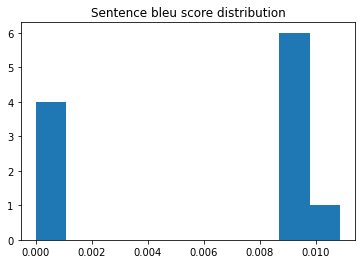

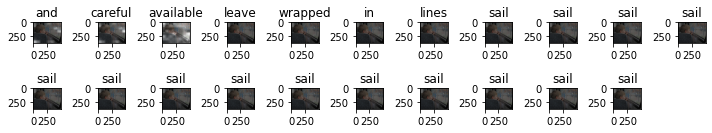

Epoch 40 Loss 1.387597
Time taken for 1 epoch 326.83 sec



In [ ]:
EPOCHS = 40

with tf.device('/device:GPU:0'):
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if epoch % 3 == 0:
            ckpt_manager.save()
            # val_set = image_train_set #should be {(img_name ,caption), ... }
            att_plots , hyps, corpus_bleu_score, img_name  = evaluate_bleu_v2(validation_set)
            plot_attention(img_name, hyps[0], att_plots[0])
            if (max_bleu_score < corpus_bleu_score):
                max_bleu_score = corpus_bleu_score
            

        print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 40 Batch 0 Loss 1.4356
Epoch 40 Batch 100 Loss 1.4088
Epoch 40 Batch 200 Loss 1.4455
Epoch 40 Batch 300 Loss 1.4698
Epoch 40 Batch 400 Loss 1.3397
Epoch 40 Batch 500 Loss 1.3206
Epoch 40 Batch 600 Loss 1.4675
Epoch 40 Batch 700 Loss 1.2993
Epoch 40 Batch 800 Loss 1.2094
Epoch 40 Batch 900 Loss 1.4234
Epoch 40 Batch 1000 Loss 1.3377
Epoch 40 Batch 1100 Loss 1.2766
Epoch 40 Batch 1200 Loss 1.4480
Epoch 40 Batch 1300 Loss 1.2137
Epoch 40 Batch 1400 Loss 1.2498
Epoch 40 Batch 1500 Loss 1.4534


100%|██████████| 11/11 [00:26<00:00,  2.41s/it]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean sentence bleu score: 0.014
Max sentence bleu score: 0.063
Corpus bleu score: 0.527
----------------------------------------------------

Real Caption: [['a', 'boy', 'in', 'a', 'green', 'uniform', 'is', 'kicking', 'a', 'soccer', 'ball', 'in', 'a', 'game', 'while', 'two', 'others', 'stand', 'behind', 'him', '.'], ['some', 'children', 'are', 'playing', 'soccer', 'on', 'a', 'sports-field', 'by', 'the', 'goal', '.'], ['the', 'little', 'boy', 'gets', 'ready', 'to', 'kick', 'the', 'soccer', 'ball', '.'], ['boys', 'play', 'soccer', 'near', 'a', 'goal', 'post', '.'], ['three', 'boys', 'play', 'soccer', '.']]
----------------------------------------------------

Predicted Caption: ['in', 'bathtub', 'tug', 'wrestle']
----------------------------------------------------



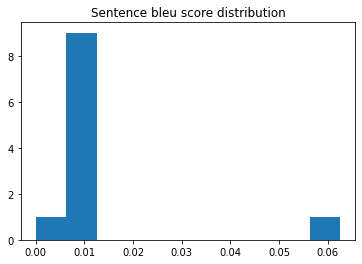

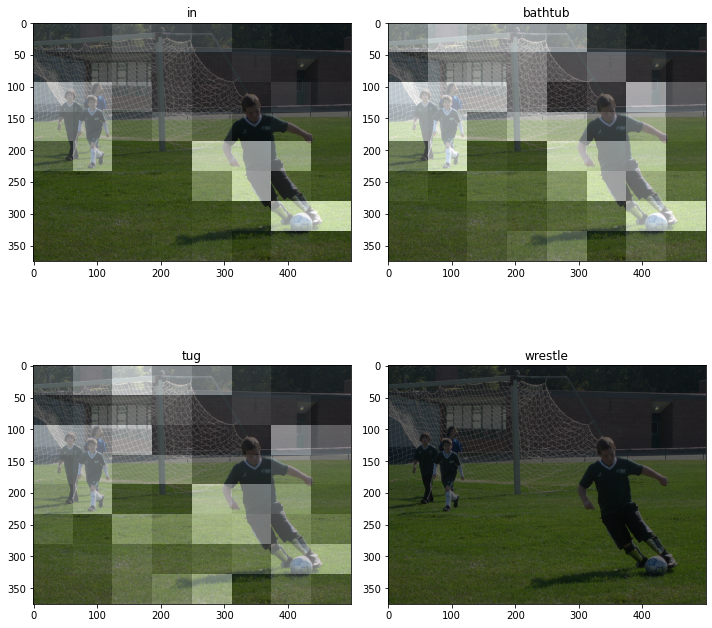

Epoch 40 Loss 1.383709
Time taken for 1 epoch 272.71 sec

Epoch 41 Batch 0 Loss 1.3375
Epoch 41 Batch 100 Loss 1.3265
Epoch 41 Batch 200 Loss 1.4503
Epoch 41 Batch 300 Loss 1.4133
Epoch 41 Batch 400 Loss 1.4993
Epoch 41 Batch 500 Loss 1.3259
Epoch 41 Batch 600 Loss 1.4672
Epoch 41 Batch 700 Loss 1.3884
Epoch 41 Batch 800 Loss 1.3272
Epoch 41 Batch 900 Loss 1.3245
Epoch 41 Batch 1000 Loss 1.3869
Epoch 41 Batch 1100 Loss 1.3920
Epoch 41 Batch 1200 Loss 1.3202
Epoch 41 Batch 1300 Loss 1.3975
Epoch 41 Batch 1400 Loss 1.3740
Epoch 41 Batch 1500 Loss 1.3385
Epoch 41 Loss 1.381558
Time taken for 1 epoch 240.55 sec

Epoch 42 Batch 0 Loss 1.4640
Epoch 42 Batch 100 Loss 1.2970
Epoch 42 Batch 200 Loss 1.1921
Epoch 42 Batch 300 Loss 1.4297
Epoch 42 Batch 400 Loss 1.3848
Epoch 42 Batch 500 Loss 1.3679
Epoch 42 Batch 600 Loss 1.4249
Epoch 42 Batch 700 Loss 1.3302
Epoch 42 Batch 800 Loss 1.3193
Epoch 42 Batch 900 Loss 1.3529
Epoch 42 Batch 1000 Loss 1.4326
Epoch 42 Batch 1100 Loss 1.3161
Epoch 42 Bat

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Mean sentence bleu score: 0.005
Max sentence bleu score: 0.012
Corpus bleu score: 0.474
----------------------------------------------------

Real Caption: [['three', 'men', ',', 'one', 'in', 'a', 'blue', 'shirt', ',', 'one', 'in', 'a', 'striped', 'shirt', 'and', 'one', 'in', 'a', 'white', 'shirt', 'are'], ['a', 'man', 'wearing', 'a', 'light', 'blue', 'shirt', 'and', 'glasses', 'is', 'talking', 'to', 'two', 'gentleman', 'in', 'front', 'of', 'his', 'kiosk'], ['men', 'discuss', 'something', 'while', 'in', 'front', 'of', 'stand', '.'], ['a', 'man', 'explains', 'a', 'display', 'to', 'two', 'other', 'men', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



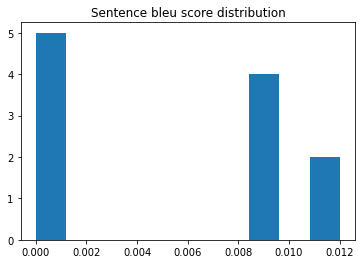

<Figure size 720x720 with 0 Axes>

Epoch 43 Loss 1.374356
Time taken for 1 epoch 268.70 sec

Epoch 44 Batch 0 Loss 1.3720
Epoch 44 Batch 100 Loss 1.2564
Epoch 44 Batch 200 Loss 1.2370
Epoch 44 Batch 300 Loss 1.3563
Epoch 44 Batch 400 Loss 1.4307
Epoch 44 Batch 500 Loss 1.3109
Epoch 44 Batch 600 Loss 1.4272
Epoch 44 Batch 700 Loss 1.4215
Epoch 44 Batch 800 Loss 1.4494
Epoch 44 Batch 900 Loss 1.3525
Epoch 44 Batch 1000 Loss 1.3808
Epoch 44 Batch 1100 Loss 1.4013
Epoch 44 Batch 1200 Loss 1.3446
Epoch 44 Batch 1300 Loss 1.3554
Epoch 44 Batch 1400 Loss 1.3718
Epoch 44 Batch 1500 Loss 1.3459
Epoch 44 Loss 1.372809
Time taken for 1 epoch 247.19 sec

Epoch 45 Batch 0 Loss 1.4299
Epoch 45 Batch 100 Loss 1.2781
Epoch 45 Batch 200 Loss 1.2898
Epoch 45 Batch 300 Loss 1.3905
Epoch 45 Batch 400 Loss 1.3715
Epoch 45 Batch 500 Loss 1.2160
Epoch 45 Batch 600 Loss 1.4064
Epoch 45 Batch 700 Loss 1.3068
Epoch 45 Batch 800 Loss 1.4516
Epoch 45 Batch 900 Loss 1.3092
Epoch 45 Batch 1000 Loss 1.3597
Epoch 45 Batch 1100 Loss 1.3255
Epoch 45 Bat

100%|██████████| 11/11 [00:25<00:00,  2.34s/it]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean sentence bleu score: 0.010
Max sentence bleu score: 0.023
Corpus bleu score: 0.143
----------------------------------------------------

Real Caption: [['people', 'waiting', 'for', 'a', 'train', 'on', 'the', 'underground', 'platform', 'of', 'an', 'urban', 'metro', 'system', '.'], ['two', 'people', 'are', 'standing', 'while', 'others', 'are', 'walking', 'or', 'rushing', 'by', '.'], ['there', 'are', 'several', 'people', 'waiting', 'to', 'get', 'on', 'the', 'subway', '.'], ['people', 'waiting', 'at', 'a', 'underground', 'subway', 'station', '.'], ['several', 'people', 'waiting', 'on', 'the', 'subway', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



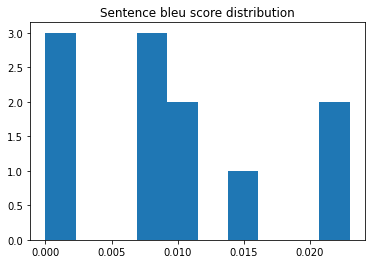

<Figure size 720x720 with 0 Axes>

Epoch 46 Loss 1.366722
Time taken for 1 epoch 266.44 sec

Epoch 47 Batch 0 Loss 1.5488
Epoch 47 Batch 100 Loss 1.3350
Epoch 47 Batch 200 Loss 1.5181
Epoch 47 Batch 300 Loss 1.3898
Epoch 47 Batch 400 Loss 1.3638
Epoch 47 Batch 500 Loss 1.3540
Epoch 47 Batch 600 Loss 1.3629
Epoch 47 Batch 700 Loss 1.4201
Epoch 47 Batch 800 Loss 1.3889
Epoch 47 Batch 900 Loss 1.3155
Epoch 47 Batch 1000 Loss 1.4531
Epoch 47 Batch 1100 Loss 1.3184
Epoch 47 Batch 1200 Loss 1.4156
Epoch 47 Batch 1300 Loss 1.2828
Epoch 47 Batch 1400 Loss 1.3839
Epoch 47 Batch 1500 Loss 1.3445
Epoch 47 Loss 1.365654
Time taken for 1 epoch 243.27 sec

Epoch 48 Batch 0 Loss 1.3421
Epoch 48 Batch 100 Loss 1.3057
Epoch 48 Batch 200 Loss 1.3850
Epoch 48 Batch 300 Loss 1.3691
Epoch 48 Batch 400 Loss 1.3654
Epoch 48 Batch 500 Loss 1.3344
Epoch 48 Batch 600 Loss 1.3716
Epoch 48 Batch 700 Loss 1.4736
Epoch 48 Batch 800 Loss 1.2453
Epoch 48 Batch 900 Loss 1.2821
Epoch 48 Batch 1000 Loss 1.3300
Epoch 48 Batch 1100 Loss 1.3075
Epoch 48 Bat

100%|██████████| 11/11 [00:26<00:00,  2.44s/it]


Mean sentence bleu score: 0.006
Max sentence bleu score: 0.024
Corpus bleu score: 0.392
----------------------------------------------------

Real Caption: [['a', 'young', 'boy', 'is', 'following', 'through', 'on', 'a', 'kick', 'during', 'a', 'soccer', 'game', ',', 'while', 'two', 'players', 'on', 'the', 'opposing', 'team'], ['a', 'kid', 'with', 'red', 'socks', 'kicked', 'another', 'kid', 'wearing', 'blue', 'socks', 'in', 'the', 'face', 'while', 'playing', 'soccer', '.'], ['a', 'group', 'of', 'children', 'in', 'soccer', 'uniforms', 'chase', 'after', 'a', 'soccer', 'ball', 'on', 'a', 'grassy', 'field', '.'], ['the', 'boys', 'are', 'on', 'the', 'soccer', 'field', 'playing', 'soccer', '.']]
----------------------------------------------------

Predicted Caption: ['is', 'occurring', 'grabbing', 'bubbles', 'floating', 'island', 'fair', 'enjoys', 'being', 'enjoyed', 'chasing', 'geese', 'are', 'scooping', 'fun', 'approach', 'picture', 'reaches', 'its', 'owners', 'are']
-----------------------

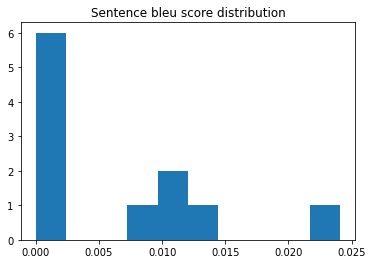

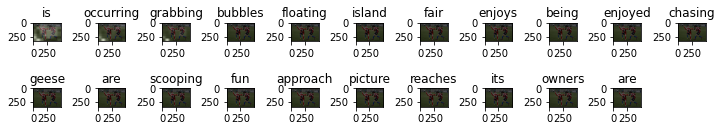

Epoch 49 Loss 1.358547
Time taken for 1 epoch 270.41 sec

Epoch 50 Batch 0 Loss 1.4180
Epoch 50 Batch 100 Loss 1.2740
Epoch 50 Batch 200 Loss 1.2774
Epoch 50 Batch 300 Loss 1.2350
Epoch 50 Batch 400 Loss 1.4340
Epoch 50 Batch 500 Loss 1.3234
Epoch 50 Batch 600 Loss 1.3537
Epoch 50 Batch 700 Loss 1.3137
Epoch 50 Batch 800 Loss 1.3521
Epoch 50 Batch 900 Loss 1.3772
Epoch 50 Batch 1000 Loss 1.3053
Epoch 50 Batch 1100 Loss 1.4454
Epoch 50 Batch 1200 Loss 1.4218
Epoch 50 Batch 1300 Loss 1.2734
Epoch 50 Batch 1400 Loss 1.4441
Epoch 50 Batch 1500 Loss 1.4144
Epoch 50 Loss 1.357072
Time taken for 1 epoch 245.00 sec

Epoch 51 Batch 0 Loss 1.3838
Epoch 51 Batch 100 Loss 1.3932
Epoch 51 Batch 200 Loss 1.3070
Epoch 51 Batch 300 Loss 1.3415
Epoch 51 Batch 400 Loss 1.2814
Epoch 51 Batch 500 Loss 1.2119
Epoch 51 Batch 600 Loss 1.3643
Epoch 51 Batch 700 Loss 1.4598
Epoch 51 Batch 800 Loss 1.3688
Epoch 51 Batch 900 Loss 1.3348
Epoch 51 Batch 1000 Loss 1.3631
Epoch 51 Batch 1100 Loss 1.3835
Epoch 51 Bat

100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Mean sentence bleu score: 0.012
Max sentence bleu score: 0.024
Corpus bleu score: 0.198
----------------------------------------------------

Real Caption: [['a', 'young', 'man', 'poses', 'with', 'a', 'basketball', ',', 'with', 'a', 'dilapidated', 'court', 'in', 'the', 'background', '.'], ['a', 'boy', 'prepares', 'to', 'play', 'some', 'basketball', 'while', 'listening', 'to', 'his', 'favorite', 'music', '.'], ['a', 'black', 'man', 'holding', 'a', 'basketball', 'while', 'listening', 'to', 'music', 'on', 'his', 'ipod', '.'], ['a', 'young', 'man', 'is', 'pointing', 'to', 'his', 'basketball', '.']]
----------------------------------------------------

Predicted Caption: ['.', 'prove', 'watering', 'plants', 'new', 'york', 'pajamas', 'waters', 'plants', 'new', 'york', 'overlooks', 'a', 'lot', 'scared', 'interviewed', 'cheerleader', 'is', 'touching', 'the', 'hospital']
----------------------------------------------------



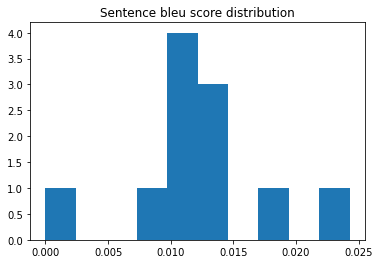

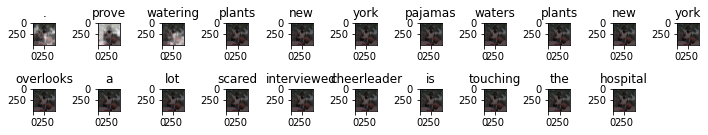

Epoch 52 Loss 1.352374
Time taken for 1 epoch 300.32 sec

Epoch 53 Batch 0 Loss 1.4249
Epoch 53 Batch 100 Loss 1.3544
Epoch 53 Batch 300 Loss 1.2403
Epoch 53 Batch 400 Loss 1.3110
Epoch 53 Batch 500 Loss 1.2673
Epoch 53 Batch 600 Loss 1.3917
Epoch 53 Batch 700 Loss 1.3491
Epoch 53 Batch 800 Loss 1.3846
Epoch 53 Batch 900 Loss 1.3687
Epoch 53 Batch 1000 Loss 1.3914
Epoch 53 Batch 1100 Loss 1.4050
Epoch 53 Batch 1200 Loss 1.3995
Epoch 53 Batch 1300 Loss 1.4326
Epoch 53 Batch 1400 Loss 1.3868
Epoch 53 Batch 1500 Loss 1.2937
Epoch 53 Loss 1.352214
Time taken for 1 epoch 252.87 sec

Epoch 54 Batch 0 Loss 1.3874
Epoch 54 Batch 100 Loss 1.3631
Epoch 54 Batch 200 Loss 1.3457
Epoch 54 Batch 300 Loss 1.3720
Epoch 54 Batch 400 Loss 1.3252
Epoch 54 Batch 500 Loss 1.3579
Epoch 54 Batch 600 Loss 1.4931
Epoch 54 Batch 700 Loss 1.3189
Epoch 54 Batch 800 Loss 1.2194
Epoch 54 Batch 900 Loss 1.3334
Epoch 54 Batch 1000 Loss 1.3167
Epoch 54 Batch 1100 Loss 1.3394
Epoch 54 Batch 1200 Loss 1.2609
Epoch 54 Ba

100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


Mean sentence bleu score: 0.004
Max sentence bleu score: 0.011
Corpus bleu score: 0.333
----------------------------------------------------

Real Caption: [['three', 'people', 'walking', 'up', 'the', 'subway', 'stairs', 'one', 'is', 'a', 'older', 'black', 'man', 'with', 'a', 'cane', '.'], ['young', 'woman', 'and', 'elderly', 'man', 'coming', 'out', 'from', 'an', 'underground', 'subway', 'tunnel', '.'], ['woman', 'and', 'man', 'with', 'cane', 'climb', 'stairs', 'from', 'underground', 'station', '.'], ['a', 'group', 'of', 'people', 'walking', 'out', 'of', 'a', 'train', 'station', 'terminal', '.'], ['pedestrians', 'exit', 'a', 'subway', 'station', 'terminal', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



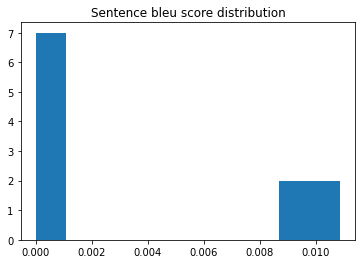

<Figure size 720x720 with 0 Axes>

Epoch 55 Loss 1.346590
Time taken for 1 epoch 273.43 sec

Epoch 56 Batch 0 Loss 1.3339
Epoch 56 Batch 100 Loss 1.3619
Epoch 56 Batch 200 Loss 1.2445
Epoch 56 Batch 300 Loss 1.3412
Epoch 56 Batch 400 Loss 1.4551
Epoch 56 Batch 500 Loss 1.2594
Epoch 56 Batch 600 Loss 1.4187
Epoch 56 Batch 700 Loss 1.2714
Epoch 56 Batch 800 Loss 1.3047
Epoch 56 Batch 900 Loss 1.3309
Epoch 56 Batch 1000 Loss 1.3843
Epoch 56 Batch 1100 Loss 1.2544
Epoch 56 Batch 1200 Loss 1.3915
Epoch 56 Batch 1300 Loss 1.3719
Epoch 56 Batch 1400 Loss 1.3529
Epoch 56 Batch 1500 Loss 1.3604
Epoch 56 Loss 1.344726
Time taken for 1 epoch 253.86 sec

Epoch 57 Batch 0 Loss 1.3089
Epoch 57 Batch 100 Loss 1.3132
Epoch 57 Batch 200 Loss 1.4480
Epoch 57 Batch 300 Loss 1.4859
Epoch 57 Batch 400 Loss 1.3842
Epoch 57 Batch 500 Loss 1.2485
Epoch 57 Batch 600 Loss 1.3567
Epoch 57 Batch 700 Loss 1.3737
Epoch 57 Batch 800 Loss 1.3661
Epoch 57 Batch 900 Loss 1.3896
Epoch 57 Batch 1000 Loss 1.3055
Epoch 57 Batch 1100 Loss 1.3416
Epoch 57 Bat

100%|██████████| 11/11 [00:25<00:00,  2.35s/it]


Mean sentence bleu score: 0.009
Max sentence bleu score: 0.027
Corpus bleu score: 0.190
----------------------------------------------------

Real Caption: [['a', 'man', 'with', 'headphones', 'has', 'his', 'mouth', 'wide', 'open', 'while', 'a', 'woman', 'stands', 'next', 'to', 'him', '.'], ['man', 'looking', 'very', 'exciting', 'holding', 'headphones', 'standing', 'outside', 'next', 'to', 'a', 'woman', '.'], ['man', 'and', 'woman', 'looking', 'surprised', ',', 'with', 'the', 'man', 'holding', 'headphones', '.'], ['an', 'excited', 'couple', 'reaching', 'for', 'a', 'large', 'black', 'set', 'of', 'earphones'], ['a', 'woman', 'and', 'a', 'man', 'are', 'amused', 'by', 'headphones', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



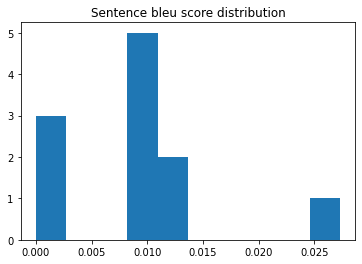

<Figure size 720x720 with 0 Axes>

Epoch 58 Loss 1.341594
Time taken for 1 epoch 290.59 sec

Epoch 59 Batch 0 Loss 1.4198
Epoch 59 Batch 100 Loss 1.2884
Epoch 59 Batch 200 Loss 1.3981
Epoch 59 Batch 300 Loss 1.4288
Epoch 59 Batch 400 Loss 1.2811
Epoch 59 Batch 500 Loss 1.2804
Epoch 59 Batch 600 Loss 1.3579
Epoch 59 Batch 700 Loss 1.2438
Epoch 59 Batch 800 Loss 1.3741
Epoch 59 Batch 900 Loss 1.2115
Epoch 59 Batch 1000 Loss 1.2875
Epoch 59 Batch 1100 Loss 1.3281
Epoch 59 Batch 1200 Loss 1.4575
Epoch 59 Batch 1300 Loss 1.4664
Epoch 59 Batch 1400 Loss 1.3446
Epoch 59 Batch 1500 Loss 1.4634
Epoch 59 Loss 1.339529
Time taken for 1 epoch 254.77 sec

Epoch 60 Batch 0 Loss 1.3602
Epoch 60 Batch 100 Loss 1.2980
Epoch 60 Batch 200 Loss 1.4063
Epoch 60 Batch 300 Loss 1.4060
Epoch 60 Batch 400 Loss 1.4415
Epoch 60 Batch 500 Loss 1.3304
Epoch 60 Batch 600 Loss 1.4836
Epoch 60 Batch 700 Loss 1.3358
Epoch 60 Batch 800 Loss 1.3541
Epoch 60 Batch 900 Loss 1.3538
Epoch 60 Batch 1000 Loss 1.3511
Epoch 60 Batch 1100 Loss 1.3610
Epoch 60 Bat

100%|██████████| 11/11 [00:27<00:00,  2.46s/it]


Mean sentence bleu score: 0.008
Max sentence bleu score: 0.014
Corpus bleu score: 0.560
----------------------------------------------------

Real Caption: [['a', 'man', 'on', 'a', 'jet', 'ski', 'is', 'leaping', 'up', 'into', 'the', 'air', 'above', 'blue', 'water', 'and', 'a', 'small', 'wave', '.'], ['a', 'male', 'riding', 'a', 'blue', 'jet', 'ski', 'is', 'airborne', 'after', 'going', 'over', 'a', 'wave', 'in', 'the', 'ocean', '.'], ['a', 'man', 'jumping', 'a', 'wave', 'on', 'a', 'ski', 'mobile', 'on', 'the', 'ocean', '.'], ['a', 'person', 'on', 'a', 'jet', 'ski', 'is', 'riding', 'through', 'the', 'sea', '.'], ['a', 'man', 'on', 'a', 'jet', 'ski', 'jumping', 'a', 'ramp', 'in', 'the', 'water', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



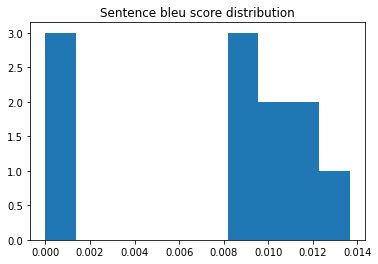

<Figure size 720x720 with 0 Axes>

Epoch 61 Loss 1.335479
Time taken for 1 epoch 286.18 sec

Epoch 62 Batch 0 Loss 1.3554
Epoch 62 Batch 100 Loss 1.3828
Epoch 62 Batch 200 Loss 1.3158
Epoch 62 Batch 300 Loss 1.3291
Epoch 62 Batch 400 Loss 1.3855
Epoch 62 Batch 500 Loss 1.2995
Epoch 62 Batch 600 Loss 1.3622
Epoch 62 Batch 700 Loss 1.3090
Epoch 62 Batch 800 Loss 1.2759
Epoch 62 Batch 900 Loss 1.3171
Epoch 62 Batch 1000 Loss 1.3487
Epoch 62 Batch 1100 Loss 1.3259
Epoch 62 Batch 1200 Loss 1.3647
Epoch 62 Batch 1300 Loss 1.3591
Epoch 62 Batch 1400 Loss 1.3098
Epoch 62 Batch 1500 Loss 1.4039
Epoch 62 Loss 1.334124
Time taken for 1 epoch 245.83 sec

Epoch 63 Batch 0 Loss 1.3263
Epoch 63 Batch 100 Loss 1.3653
Epoch 63 Batch 200 Loss 1.3038
Epoch 63 Batch 300 Loss 1.4351
Epoch 63 Batch 400 Loss 1.4066
Epoch 63 Batch 500 Loss 1.3868
Epoch 63 Batch 600 Loss 1.2879
Epoch 63 Batch 700 Loss 1.2281
Epoch 63 Batch 800 Loss 1.4299
Epoch 63 Batch 900 Loss 1.2789
Epoch 63 Batch 1000 Loss 1.3298
Epoch 63 Batch 1100 Loss 1.3399
Epoch 63 Bat

100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Mean sentence bleu score: 0.008
Max sentence bleu score: 0.011
Corpus bleu score: 0.520
----------------------------------------------------

Real Caption: [['a', 'woman', 'waring', 'a', 'purple', 'sweatshirt', 'in', 'a', 'jewelry', 'store', 'is', 'bent', 'over', 'inside', 'the', 'display', 'case', '.'], ['a', 'woman', 'working', 'in', 'the', 'storefront', 'of', 'a', 'jewelry', 'shop', 'fixing', 'the', 'display', 'shelf', '.'], ['lady', 'in', 'purple', 'sweater', 'putting', 'jewelry', 'away', 'into', 'a', 'window', 'case', '.'], ['a', 'woman', 'putting', 'jewelry', 'in', 'the', 'window', 'display', '.'], ['a', 'woman', 'adjusts', 'window', 'display', '.']]
----------------------------------------------------

Predicted Caption: ['.', 'blur', 'at', 'sweaters', 'wind', 'pay', 'exiting', 'scuba', 'social', 'cabin', 'sailing', 'way', 'hacky', 'as', 'clowns', 'as', 'london', 'crazy', 'practicing', 'yoga', 'maintenance']
----------------------------------------------------



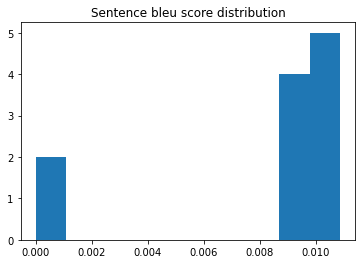

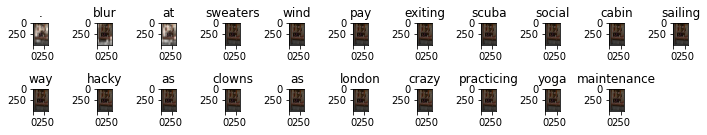

Epoch 64 Loss 1.331974
Time taken for 1 epoch 291.58 sec

Epoch 65 Batch 0 Loss 1.3588
Epoch 65 Batch 100 Loss 1.3426
Epoch 65 Batch 200 Loss 1.3473
Epoch 65 Batch 300 Loss 1.4180
Epoch 65 Batch 400 Loss 1.1444
Epoch 65 Batch 500 Loss 1.4080
Epoch 65 Batch 600 Loss 1.3436
Epoch 65 Batch 700 Loss 1.2661
Epoch 65 Batch 800 Loss 1.3457
Epoch 65 Batch 900 Loss 1.3846
Epoch 65 Batch 1000 Loss 1.3190
Epoch 65 Batch 1100 Loss 1.3900
Epoch 65 Batch 1200 Loss 1.3443
Epoch 65 Batch 1300 Loss 1.2853
Epoch 65 Batch 1400 Loss 1.3845
Epoch 65 Batch 1500 Loss 1.3448
Epoch 65 Loss 1.331277
Time taken for 1 epoch 257.68 sec

Epoch 66 Batch 0 Loss 1.3514
Epoch 66 Batch 100 Loss 1.3436
Epoch 66 Batch 200 Loss 1.3098
Epoch 66 Batch 300 Loss 1.2557
Epoch 66 Batch 400 Loss 1.3573
Epoch 66 Batch 500 Loss 1.3143
Epoch 66 Batch 600 Loss 1.4198
Epoch 66 Batch 700 Loss 1.2700
Epoch 66 Batch 800 Loss 1.2727
Epoch 66 Batch 900 Loss 1.3069
Epoch 66 Batch 1000 Loss 1.3207
Epoch 66 Batch 1100 Loss 1.3748
Epoch 66 Bat

100%|██████████| 11/11 [00:26<00:00,  2.44s/it]


Mean sentence bleu score: 0.009
Max sentence bleu score: 0.014
Corpus bleu score: 0.575
----------------------------------------------------

Real Caption: [['a', 'woman', 'in', 'a', 'striped', 'shirt', 'smiles', 'at', 'the', 'camera', 'while', 'another', 'woman', 'enjoys', 'refreshments', 'behind', 'her', '.'], ['two', 'ladies', 'one', 'with', 'her', 'fingers', 'in', 'her', 'pocket', 'and', 'the', 'other', 'with', 'a', 'drink', 'in', 'her', 'hand', 'at', 'a', 'party'], ['a', 'woman', 'in', 'a', 'striped', 'shirt', 'posing', 'for', 'the', 'camera', 'while', 'another', 'woman', 'holding', 'a', 'drink', 'looks', 'on', '.'], ['a', 'woman', 'poses', 'for', 'the', 'camera', 'in', 'front', 'of', 'other', 'people', 'eating', 'and', 'drinking', '.']]
----------------------------------------------------

Predicted Caption: []
----------------------------------------------------



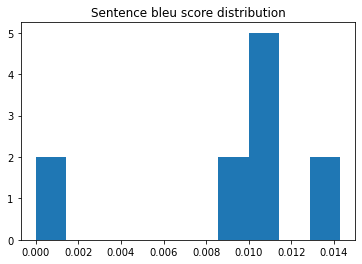

<Figure size 720x720 with 0 Axes>

Epoch 67 Loss 1.327905
Time taken for 1 epoch 283.44 sec

Epoch 68 Batch 0 Loss 1.3443
Epoch 68 Batch 100 Loss 1.2999
Epoch 68 Batch 200 Loss 1.4017
Epoch 68 Batch 300 Loss 1.3606
Epoch 68 Batch 400 Loss 1.3250
Epoch 68 Batch 500 Loss 1.3705
Epoch 68 Batch 600 Loss 1.2772
Epoch 68 Batch 700 Loss 1.3853
Epoch 68 Batch 800 Loss 1.2664
Epoch 68 Batch 900 Loss 1.3366
Epoch 68 Batch 1000 Loss 1.3377
Epoch 68 Batch 1100 Loss 1.2939
Epoch 68 Batch 1200 Loss 1.2303
Epoch 68 Batch 1300 Loss 1.3307
Epoch 68 Batch 1400 Loss 1.2999
Epoch 68 Batch 1500 Loss 1.2696
Epoch 68 Loss 1.325503
Time taken for 1 epoch 262.23 sec

Epoch 69 Batch 0 Loss 1.2744
Epoch 69 Batch 100 Loss 1.3533
Epoch 69 Batch 200 Loss 1.2593
Epoch 69 Batch 300 Loss 1.3522
Epoch 69 Batch 400 Loss 1.3833
Epoch 69 Batch 500 Loss 1.3563
Epoch 69 Batch 600 Loss 1.2966
Epoch 69 Batch 700 Loss 1.3290
Epoch 69 Batch 800 Loss 1.3750
Epoch 69 Batch 900 Loss 1.3889
Epoch 69 Batch 1000 Loss 1.3473
Epoch 69 Batch 1100 Loss 1.2581
Epoch 69 Bat

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Mean sentence bleu score: 0.009
Max sentence bleu score: 0.012
Corpus bleu score: 0.516
----------------------------------------------------

Real Caption: [['a', 'man', 'outside', 'at', 'a', 'red', 'brick', 'building', 'with', 'a', 'grocery', 'cart', ',', 'a', 'bike', ',', 'and', 'miscellaneous', '.'], ['a', 'man', 'in', 'a', 'black', 'cap', 'is', 'opening', 'a', 'bag', 'beside', 'a', 'bicycle', 'and', 'a', 'shopping', 'cart', '.'], ['a', 'man', 'fiddles', 'with', 'a', 'shopping', 'bag', 'outside', 'near', 'a', 'shopping', 'cart', '.'], ['a', 'man', 'looks', 'in', 'a', 'bag', 'near', 'some', 'grocery', 'carts', 'and', 'a', 'bike', '.'], ['a', 'man', 'gathers', 'his', 'belongings', 'by', 'the', 'side', 'of', 'a', 'building', '.']]
----------------------------------------------------

Predicted Caption: ['in', 'formal', 'not', 'wiping', 'but', 'wiping', 'the', 'native', 'goods', 'she', 'latin', 'stones', 'tongue', 'fiddling', 'his', 'partner', 'peeking', 'shines', 'hotdogs', 'on', 'sunn

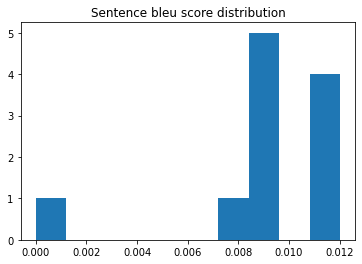

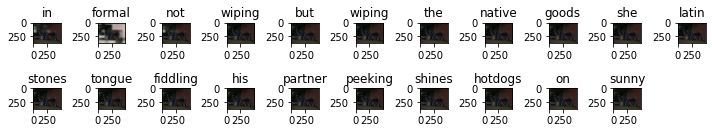

Epoch 70 Loss 1.324572
Time taken for 1 epoch 284.61 sec



In [ ]:
EPOCHS = 70

with tf.device('/device:GPU:0'):
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if epoch % 3 == 0:
            ckpt_manager.save()
            # val_set = image_train_set #should be {(img_name ,caption), ... }
            att_plots , hyps, corpus_bleu_score, s_bleus, images_ret, img_test  = evaluate_bleu_v2(validation_set)
            plot_attention(img_test, hyps[0], att_plots[0])
            if (max_bleu_score < corpus_bleu_score):
                max_bleu_score = corpus_bleu_score
            

        print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
print("The maximum bleu score found was: " + str(max_bleu_score) )

The maximum bleu score found was: 0.5048005504343401


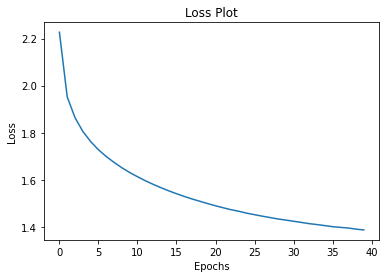

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
print("The maximum bleu score found from epoch 40 to epoch 70 was: " + str(max_bleu_score) )

The maximum bleu score found from epoch 40 to epoch 70 was: 0.5747476990532415


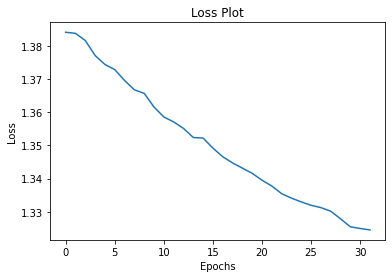

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Συμπεράσματα
Παρατηρήσαμε πως:
* Το μοντέλο μας παρουσιάζει ικανοποιητικές τιμές για το corpus_bleu.
* Όσον αφορά τα sentence bleu scores είναι πολυ μικρά γεγονός που ίσως οφείλεται σε δικό μας λάθος κατά την υλοποίηση της συνάρτησης που το υπολογίζει. 
* Τα loss plots ανταποκρίνονται στην πραγματικότητα καθώς παρατηρούμε εκθετική πτωση στα πρώτα 40 epochs και έπειτα μια σταθερή πτώση σε μικρή κλίμακα.

## Caption Evaluation with BLEU score - final part

Θα κάνουμε evaluation στο validation set για να δούμε πως αποδίδει το μοντέλο μας.

100%|██████████| 2383/2383 [1:36:44<00:00,  2.44s/it]


Mean sentence bleu score: 0.008
Max sentence bleu score: 0.044
Corpus bleu score: 0.116
----------------------------------------------------

Real Caption: [['two', 'brown', 'dogs', 'are', 'wrestling', 'with', 'each', 'other', 'on', 'some', 'wasteland', '.'], ['two', 'brown', 'dog', 'grapple', 'each', 'other', 'in', 'a', 'sandy', 'area', '.'], ['two', 'brown', 'dogs', 'biting', 'each', 'other', 'on', 'sand', '.'], ['two', 'brown', 'dogs', 'are', 'biting', 'each', 'other', '.'], ['two', 'tan', 'colored', 'dogs', 'playing', '.']]
----------------------------------------------------

Predicted Caption: ['.', 'laughs', 'shocked', 'jumped', 'numbered', 'is', 'shocked', 'jumped', 'banners', 'long-sleeved', 'laying', 'in', 'jumped', 'banners', 'long-sleeved', 'laying', 'numbered', 'is', 'shocked', 'when', 'is']
----------------------------------------------------



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


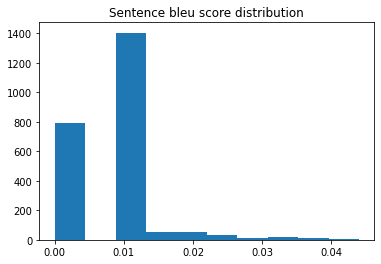

In [ ]:
att_plots , hyps, corpus_bleu_score, sentence_bleus, images_ret, img_test  = evaluate_bleu_v2(validation_set, percentage = 1)

Για τις ανάγκες του διαγωνίσμου χρειάζονται τα παρακάτω κελιά:

In [ ]:
def get_captions():
  hypotheses = []
  test_images_df = pd.read_csv("../input/neuralsntua-image-captioning/test_images.csv")
  test_images_list = list(test_images_df) + list(test_images_df['_1000400860.jpg'])
  for image in tqdm(test_images_list):
    result, att_plot = beam_search(image)
    hypotheses.append(result) 
  return hypotheses

In [ ]:
import json
test_hypotheses = get_captions()
jsonString = json.dumps(test_hypotheses)
jsonFile = open("test_hypotheses.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

100%|██████████| 2000/2000 [46:13<00:00,  1.39s/it]
